# **DSC511 Semester Project: Airline Delay and Cancellation Data, 2016-2018**
Antoniadou Maria | Korai Natalia | Constantinou Ioannis | Christodoulou Sotiris

# **1. Import the Data**

In [ ]:
#library installation
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=0ab2c3f43b88d8bf82233494e7e4695e8e6d00b83c6dd990965f4545ea8c18bb
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.9/dist-packages/pyspark'

In [ ]:
# import libraries
from pyspark.sql import SparkSession
import pandas as pd
from functools import reduce
from pyspark.sql import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as f
from pyspark.sql.functions import col,isnan,when,count,round
from pyspark.sql.functions import *
from pyspark.sql.functions import month, year
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import rand
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import GBTClassifier

spark = SparkSession.builder.appName("SimpleApp").master("local").config("spark.driver.memory", "15g").config("spark.driver.maxResultSize","0").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
# run only once
df1 = spark.read.csv('/content/drive/MyDrive/2016.csv',header=True)
df2 = spark.read.csv('/content/drive/MyDrive/2017.csv')
df3 = spark.read.csv('/content/drive/MyDrive/2018.csv')
#df1.show(5) much computation time
'''

In [ ]:
'''
# run only once
#Combine all the csv files
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)
 
df = unionAll(df1,df2,df3)
'''

In [ ]:
'''
# run only once
df1.write.parquet("/content/drive/MyDrive/2016.parquet")
df2.write.parquet("/content/drive/MyDrive/2017.parquet")
df3.write.parquet("/content/drive/MyDrive/2018.parquet")
df.write.parquet("/content/drive/MyDrive/2016_2017_2018.parquet")
'''

Given that the dataset is extremely large, we converted the files into parquet to achieve faster execution.

In [ ]:
df1 = spark.read.parquet("/content/drive/MyDrive/2016.parquet", header = True)
df2 = spark.read.parquet("/content/drive/MyDrive/2017.parquet", header = False)
df3 = spark.read.parquet("/content/drive/MyDrive/2018.parquet", header = False)
df = spark.read.parquet("/content/drive/MyDrive/2016_2017_2018.parquet", header = True)

In [ ]:
# rename the names of the columns of df2 and df3 in order to be the same as df
for c,n in zip(df2.columns,df.columns):
    df2=df2.withColumnRenamed(c,n)
for c,n in zip(df3.columns,df.columns):
    df3=df3.withColumnRenamed(c,n)

In [ ]:
df.show(10)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

In [ ]:
# get the shape of the dataframe
num_rows = df.count()
num_cols = len(df.columns)

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  18505727
Number of columns:  28


In [ ]:
# print the schema of the dataframe
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

# **2. Data Pre-processing** 

## 2.1. Data Type Conversion

The columns are set as integers, even that this is not ideal for some of them; this takes place just to proceed to the step of filling missing values and later on we change their data type into a more suitable one.

In [ ]:
# define helper function, which will change the data type of columns into suitable ones
def change_type(df):
  df = df.withColumn("CRS_DEP_TIME", col("CRS_DEP_TIME").cast("integer"))
  df = df.withColumn("DEP_TIME", col("DEP_TIME").cast("integer"))
  df = df.withColumn("DEP_DELAY", col("DEP_DELAY").cast("integer"))
  df = df.withColumn("TAXI_OUT", col("TAXI_OUT").cast("integer"))
  df = df.withColumn("WHEELS_OFF", col("WHEELS_OFF").cast("integer"))
  df = df.withColumn("WHEELS_ON", col("WHEELS_ON").cast("integer"))
  df = df.withColumn("TAXI_IN", col("TAXI_IN").cast("integer"))
  df = df.withColumn("CRS_ARR_TIME", col("CRS_ARR_TIME").cast("integer"))
  df = df.withColumn("ARR_TIME", col("ARR_TIME").cast("integer"))
  df = df.withColumn("ARR_DELAY", col("ARR_DELAY").cast("integer"))
  df = df.withColumn("DIVERTED", col("DIVERTED").cast("integer"))
  df = df.withColumn("CRS_ELAPSED_TIME", col("CRS_ELAPSED_TIME").cast("integer"))
  df = df.withColumn("ACTUAL_ELAPSED_TIME", col("ACTUAL_ELAPSED_TIME").cast("integer"))
  df = df.withColumn("AIR_TIME", col("AIR_TIME").cast("integer"))
  df = df.withColumn("DISTANCE", col("DISTANCE").cast("integer"))
  df = df.withColumn("CARRIER_DELAY", col("CARRIER_DELAY").cast("integer"))
  df = df.withColumn("WEATHER_DELAY", col("WEATHER_DELAY").cast("integer"))
  df = df.withColumn("NAS_DELAY", col("NAS_DELAY").cast("integer"))
  df = df.withColumn("SECURITY_DELAY", col("SECURITY_DELAY").cast("integer"))
  df = df.withColumn("LATE_AIRCRAFT_DELAY", col("LATE_AIRCRAFT_DELAY").cast("integer"))
  df = df.withColumn("CANCELLED", col("CANCELLED").cast("integer"))
  return (df)

In [ ]:
# change the data types for all dataframes
df = change_type(df)
df1 = change_type(df1)
df2 = change_type(df2)
df3 = change_type(df3)

In [ ]:
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: integer (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: integer (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- CARRIER_DELAY: integer (nullable = true)
 |-- WEA

## 2.2. Duplicated Records

In [ ]:
# number of observations 
dc1=df1.count()
dc2=df2.count()
dc3=df3.count()
print('Observations of 2016:', dc1)
print('Observations of 2017:', dc2)
print('Observations of 2018:', dc3)
print('Sum of the Observations:', dc1+dc2+dc3) # check if the union executed well
print('Overall observations:', df.count())

Observations of 2016: 5617658
Observations of 2017: 5674622
Observations of 2018: 7213447
Sum of the Observations: 18505727
Overall observations: 18505727


In [ ]:
# check for duplicates 
print('Duplicates of 2016:', dc1 - df1.distinct().count())
print('Duplicates of 2017:', dc2 - df2.distinct().count()) 
print('Duplicates of 2018:',dc3 - df3.distinct().count()) 

Duplicates of 2016: 0
Duplicates of 2017: 0
Duplicates of 2018: 0


## 2.3 Dealing with Missing Values

In [ ]:
# define helper function
def find_nulls(df):
    count_nulls = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).cast('integer').alias(c)

                    for c in df.columns])
    total_rows = df.count()
    percent_nulls = count_nulls.select([round(((count_nulls[c] / total_rows) * 100), 2).alias(c + '_percentage')
                                    for c in count_nulls.columns])
    result = count_nulls.union(percent_nulls)
    result_t = result.select([col(c).alias(c.split('_')[0]) for c in result.columns]).toPandas().transpose()
    print(result_t.to_string(header=["Count", "Percentage(%)"]))

In [ ]:
find_nulls(df)

                   Count Percentage(%)
FL                   0.0          0.00
OP                   0.0          0.00
OP                   0.0          0.00
ORIGIN               0.0          0.00
DEST                 0.0          0.00
CRS                  2.0          0.00
DEP             256083.0          1.38
DEP             261035.0          1.41
TAXI            263395.0          1.42
WHEELS          263390.0          1.42
WHEELS          271766.0          1.47
TAXI            271766.0          1.47
CRS                  2.0          0.00
ARR             271765.0          1.47
ARR             311766.0          1.68
CANCELLED            2.0          0.00
CANCELLATION  18240587.0         98.57
DIVERTED             2.0          0.00
CRS                 25.0          0.00
ACTUAL          309168.0          1.67
AIR             309168.0          1.67
DISTANCE             2.0          0.00
CARRIER       15159305.0         81.92
WEATHER       15159305.0         81.92
NAS           15159305.0 

* We can see that we have millions of missing values in columns CANCELLATION_CODE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, Unnamed: 27.
  * From the missing values in CANCELLATION_CODE, we can assume that we have around 18 240 587 delayed flights, i.e., the majority of our observations are about delayed flights.
  * The fact that we have same number of missing values in CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY which represent the cause of the delay, creates the impression that for the majority of delayed flights the cause will be missing.

* Moreover, we have thousands of missing values in columns DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, and ARR_DELAY. All these columns are related with delayed flights.
  * The number of missings values differs between the columns, therefore the number of cancelled flights is not clear at this point. We can assume that on average they are around 270 000.



At this point we decided to drop three columns from all dataframes:
  * the last column (Unnamed: 27) since it is a 100% empty column
  * DIVERTED: this column has very low variability and so it will not be useful for our analysis
  * OP_CARRIER_FL_NUM: we consider this feature offers no value

In [ ]:
df.groupBy('DIVERTED').count().show()

+--------+--------+
|DIVERTED|   count|
+--------+--------+
|    null|       2|
|       1|   44041|
|       0|18461684|
+--------+--------+



In [ ]:
df = df.drop('Unnamed: 27', 'DIVERTED', 'OP_CARRIER_FL_NUM')
df1 = df1.drop('Unnamed: 27', 'DIVERTED', 'OP_CARRIER_FL_NUM')
df2 = df2.drop('Unnamed: 27', 'DIVERTED', 'OP_CARRIER_FL_NUM')
df3 = df3.drop('Unnamed: 27', 'DIVERTED', 'OP_CARRIER_FL_NUM')

### 2.3.1. Split dataframe into 2: df and df_cancel

In this section we split the initial dataframe into 2 separate ones, since we expect that the missing values will fall dramatically in each dataframe.
  * df_cancel: cancelled flights 
  * df: rest of flights; non cancelled ones

In [ ]:
# split all dfs
df_cancel = df.filter(df.CANCELLED == 1)
df1_cancel = df1.filter(df1.CANCELLED == 1)
df2_cancel = df2.filter(df2.CANCELLED == 1)
df3_cancel = df3.filter(df3.CANCELLED == 1)

df = df.filter(df.CANCELLED == 0)
df1 = df1.filter(df1.CANCELLED == 0)
df2 = df2.filter(df2.CANCELLED == 0)
df3 = df3.filter(df3.CANCELLED == 0)

In [ ]:
# drop the unnecessary columns from all dataframes

# cancelled flights
df_cancel = df_cancel.select('FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE')
df1_cancel = df1_cancel.select('FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE')
df2_cancel = df2_cancel.select('FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE')
df3_cancel = df3_cancel.select('FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE')

# non-cancelled flights
df = df.drop('CANCELLED', 'CANCELLATION_CODE')
df1 = df1.drop('CANCELLED', 'CANCELLATION_CODE')
df2 = df2.drop('CANCELLED', 'CANCELLATION_CODE')
df3 = df3.drop('CANCELLED', 'CANCELLATION_CODE')

In [ ]:
print('Missing values in df_cancel:' )
find_nulls(df_cancel)
print('\n Missing values in df:' )
find_nulls(df)

Missing values in df_cancel:
             Count Percentage(%)
FL             0.0          0.00
OP             0.0          0.00
ORIGIN         0.0          0.00
DEST           0.0          0.00
CRS            0.0          0.00
CRS            0.0          0.00
CANCELLATION   0.0          0.00
CRS           16.0          0.01
DISTANCE       0.0          0.00

 Missing values in df:
               Count Percentage(%)
FL               0.0          0.00
OP               0.0          0.00
ORIGIN           0.0          0.00
DEST             0.0          0.00
CRS              0.0          0.00
DEP              0.0          0.00
DEP           4744.0          0.03
TAXI             0.0          0.00
WHEELS           0.0          0.00
WHEELS        6626.0          0.04
TAXI          6626.0          0.04
CRS              0.0          0.00
ARR           6625.0          0.04
ARR          46626.0          0.26
CRS              7.0          0.00
ACTUAL       44028.0          0.24
AIR          44028.0  

We can clearly see that missing values have significantly decreased in most of the remaining features.

For *df_cancel* we have only 16 missing values in CRS_ELAPSE_TIME which is around 0.01%. Since the percentage is very small we are going to drop those values.

For *df* we have some null values in columns DEP_DELAY, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, ACTUAL_ELAPSED_TIME, AIR_TIME. The percentage of null values in each column does not exceed 0.30%, i.e., it is very small and hence we are going to drop these rows as well.

However, we can observe that the last features of df that present the cause of the delay, still have a huge number of null values. With this in mind, these features are not beneficial for our model. We decided to temporarily keep those features for visualation purposes and drop them at a later stage. We are going to fill them with 0.


In [ ]:
# drop NAs in cancelled flights
df_cancel = df_cancel.na.drop()
df1_cancel = df1_cancel.na.drop()
df2_cancel = df2_cancel.na.drop()
df3_cancel = df3_cancel.na.drop()

# fill the last features of non-cancelled flights with 0 
df = df.fillna(0, subset = ['CARRIER_DELAY', 'WEATHER_DELAY' ,'NAS_DELAY' ,'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'])
df1 = df1.fillna(0, subset = ['CARRIER_DELAY', 'WEATHER_DELAY' ,'NAS_DELAY' ,'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'])
df2 = df2.fillna(0, subset = ['CARRIER_DELAY', 'WEATHER_DELAY' ,'NAS_DELAY' ,'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'])
df3 = df3.fillna(0, subset = ['CARRIER_DELAY', 'WEATHER_DELAY' ,'NAS_DELAY' ,'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'])

# drop the remaining NAs in df
df = df.na.drop()
df1 = df1.na.drop()
df2 = df2.na.drop()
df3 = df3.na.drop()

In [ ]:
# check again the null values
print('Missing values in df_cancel:' )
find_nulls(df_cancel)
print('Missing values in df:' )
find_nulls(df)

Missing values in df_cancel:
             Count Percentage(%)
FL             0.0           0.0
OP             0.0           0.0
OP             0.0           0.0
ORIGIN         0.0           0.0
DEST           0.0           0.0
CRS            0.0           0.0
CRS            0.0           0.0
CANCELLATION   0.0           0.0
CRS            0.0           0.0
DISTANCE       0.0           0.0
Missing values in df:
         Count Percentage(%)
FL         0.0           0.0
OP         0.0           0.0
OP         0.0           0.0
ORIGIN     0.0           0.0
DEST       0.0           0.0
CRS        0.0           0.0
DEP        0.0           0.0
DEP        0.0           0.0
TAXI       0.0           0.0
WHEELS     0.0           0.0
WHEELS     0.0           0.0
TAXI       0.0           0.0
CRS        0.0           0.0
ARR        0.0           0.0
ARR        0.0           0.0
DIVERTED   0.0           0.0
CRS        0.0           0.0
ACTUAL     0.0           0.0
AIR        0.0           0.0
DISTAN

We have 0 NA values!

We check again the number of observations after dropping the nulls. We can see that the number of rows is not signficantly different, hence we can assume that the missing values were in same observations.

In [ ]:
# number of observations for non-cancelled flights
dc1=df1.count()
dc2=df2.count()
dc3=df3.count()
dc = df.count()
print('Non-cancelled flights')
print('Observations of 2016:', dc1)
print('Observations of 2017:', dc2)
print('Observations of 2018:', dc3)
print('Overall observations:', dc)

Non-cancelled flights
Observations of 2016: 5538145
Observations of 2017: 5579410
Observations of 2018: 7071817
Overall observations: 18189372


In [ ]:
# number of observations for cancelled flights
dc1_cancel = df1_cancel.count()
dc2_cancel = df2_cancel.count()
dc3_cancel = df3_cancel.count()
dc_cancel = df_cancel.count()
print('Cancelled flights')
print('Observations of 2016:', dc1_cancel)
print('Observations of 2017:', dc2_cancel)
print('Observations of 2018:', dc3_cancel)
print('Overall observations:', dc_cancel)

Cancelled flights
Observations of 2016: 65855
Observations of 2017: 82686
Observations of 2018: 116581
Overall observations: 265122


## 2.4. Split df into 2: df_delays, df_fixed
Before we proceed to erroneous values, we decided to split the df again into two separate ones: 
- df_delays: delayed flights, both flights that arrived late or early
- df_fixed: flights that were not cancelled and did not have any delays

In [ ]:
# delays dataframe (include negative values of DEP_DELAY and ARR_DELAY as delays as well)
df_delays = df.filter(((df.DEP_DELAY != 0) | (df.ARR_DELAY != 0)))

# flights done based on the schedule - not cancelled & no delays
df_fixed = df.filter((df.DEP_DELAY == 0) & (df.ARR_DELAY == 0))

# drop unnecessary columns
df_fixed = df_fixed.drop('DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY')

In [ ]:
num_delays = df_delays.count()
num_cancel = df_cancel.count()
num_fixed = df_fixed.count()

# count the observations of each df
print('Total of delayed and early flights:', num_delays) 
print('Total of cancelled flights:', num_cancel)
print('Total of flights done based on the schedule:', num_fixed)

# check if we inlcuded all the records of df into the 2 new dfs
print('Flights left unclassified:', dc - (num_delays + num_fixed)) # dc == df.count()

Total of delayed and early flights: 18159861
Total of cancelled flights: 265122
Total of flights done based on the schedule: 29511
Flights left unclassified: 0


We can verify that we distributed correctly the dataframe!

## 2.5. Handling Erroneous Values

We start by having a look at the basic summary statistics per feature in each df. We select only the numerical features.

In [ ]:
selected_columns = ['CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE']
df_cancel.select(selected_columns).describe().toPandas()

,summary,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE
0,count,265122,265122,265122,265122
1,mean,1388.6915570944698,1531.066324182829,130.23731715964726,694.7008018949766
2,stddev,503.0838879703942,536.3006088051019,64.33235371422084,520.7465105421801
3,min,1,1,5,31
4,max,2359,2400,712,4983


In [ ]:
selected_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
df_delays.select(selected_columns).describe().toPandas()

,summary,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,count,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861,18159861
1,mean,1329.36721663233,1333.669739762876,9.530180434751125,16.836644729824748,1356.3546385074203,1464.4155377070342,7.522786765823813,1487.895572934176,1468.8671401724937,4.371283458612376,144.40858633224119,139.24980075563354,114.89036925998498,834.4386085884688,3.654599558884289,0.5685570500787424,2.871710251526705,0.016664554866361588,4.628478488904733
2,stddev,490.38331461261697,503.9294329796526,42.89122169858077,9.432027226844346,505.61407664625267,532.4185713503188,5.89295298811225,517.7399773533543,536.7425237128027,45.15979963308259,75.61706838402732,75.05264355667552,72.89431773374321,614.3174989221685,26.684755249032357,11.242248996508234,15.977082292258086,1.257954698260504,22.82070106015584
3,min,1,1,-234,0,1,1,0,1,1,-238,-99,14,4,28,0,0,0,0,0
4,max,2359,2400,2710,196,2400,2400,414,2400,2400,2692,718,784,723,4983,2142,2692,1848,987,2454


We can observe that the minimum of CRS_ELAPSED_TIME is negative. Of course this is not possible since it represents the planned time amount needed for the flight trip. So, we remove the values that are less than or equal to 0.

In [ ]:
# Filter out the erroneous negative values 
df = df.filter(col('CRS_ELAPSED_TIME') >= 0)
df1 = df1.filter(col('CRS_ELAPSED_TIME') >= 0)
df2 = df2.filter(col('CRS_ELAPSED_TIME') >= 0)
df3 = df3.filter(col('CRS_ELAPSED_TIME') >= 0)

In [ ]:
selected_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE']
df_fixed.select(selected_columns).describe().toPandas()

,summary,CRS_DEP_TIME,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE
0,count,29511,29511,29511,29511,29511,29511,29511,29511,29511,29511,29511,29511
1,mean,1279.3239808884823,1279.3239808884823,16.792687472467893,1300.9081020636372,1434.7433838229813,7.346785944224187,1443.5350547253568,1443.5350547253568,133.76479956626343,133.76479956626343,109.62532614957135,778.2654942224933
2,stddev,478.0796999516784,478.0796999516784,6.753870238422078,480.6305197010197,491.9073188694794,4.6364218690831915,493.70057963741874,493.70057963741874,70.88307975380481,70.88307975380481,69.01338896201881,571.7696239233978
3,min,1,1,2,1,1,1,1,1,20,20,8,31
4,max,2359,2359,64,2359,2400,53,2359,2359,667,667,632,4983


At this point, none of our features violates any rules based on our descriptive summary statistics. We can see that we have some very small values in certain features, eg, the minimum for air time is 4 and 8 in df_delays and df_fixed respectively, but we will deal with these values in the next chapter.

## 2.6. Dealing with Outliers

We plot boxplots to observe the outliers of the continuous features

In [ ]:
# define helper function
def plot_boxplot2(df1, df2, x1, x2, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    x1_values = df1.select(col(x1)).toPandas()
    x2_values = df2.select(col(x2)).toPandas()
    axes[0].boxplot(x1_values, flierprops=dict(markerfacecolor='red', marker='o', markersize=5))
    axes[0].set_title(title)
    axes[0].set_ylabel('Values')
    axes[0].set_xticklabels([x1])
    axes[1].boxplot(x2_values, flierprops=dict(markerfacecolor='red', marker='o', markersize=5))
    axes[1].set_title(title)
    axes[1].set_ylabel('Values')
    axes[1].set_xticklabels([x2])
    plt.show()

In [ ]:
# define helper function
def plot_boxplot(df, x, title):
    fig, ax = plt.subplots()
    x_values = df.select(col(x)).toPandas()
    ax.boxplot(x_values, flierprops=dict(markerfacecolor='red', marker='o', markersize=5))
    ax.set_title(title)
    ax.set_ylabel('Values')
    ax.set_xticklabels([x])
    plt.show()

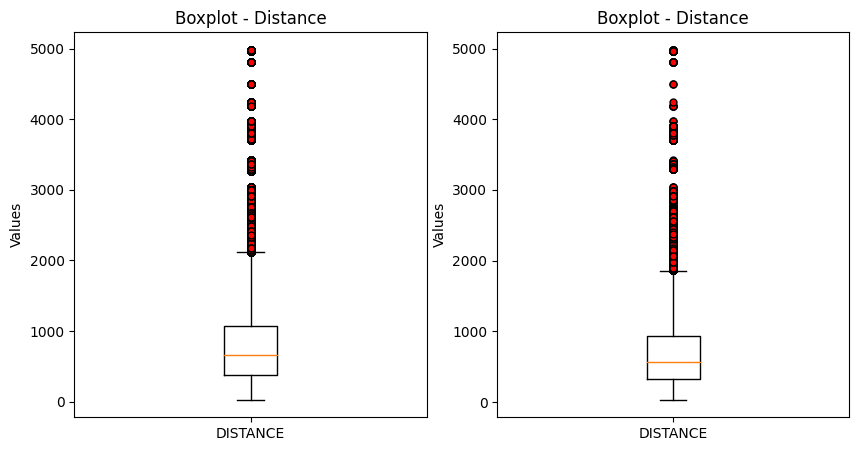

In [ ]:
plot_boxplot2(df, df_cancel, 'DISTANCE', 'DISTANCE', 'Boxplot - Distance')

We can observe that the median is around 700, which gives that 50% of the flights have distance less than 700 miles. Moreover, there are outliers only above the upper whisker. After a quick search on the internet, we found that the longest flight distance in the world is 9,537 miles, which gives that distance between 2000 and 5000 seems to be valid and hence we decided to keep them.

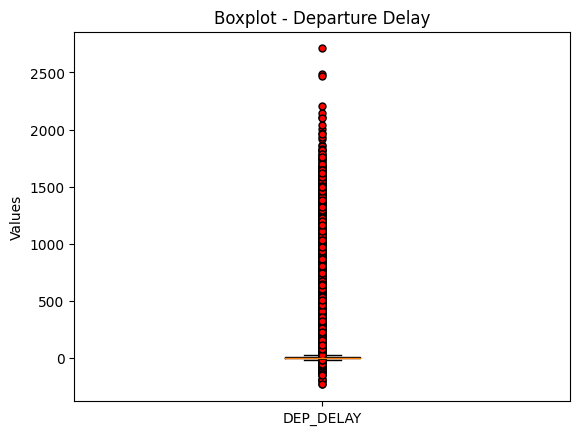

In [ ]:
plot_boxplot(df_delays, 'DEP_DELAY', 'Boxplot - Departure Delay')

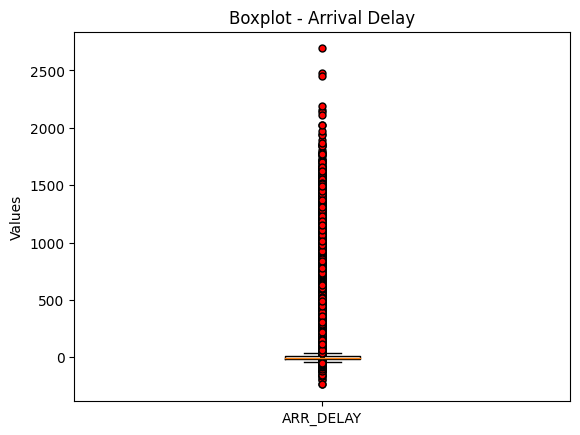

In [ ]:
plot_boxplot(df_delays, 'ARR_DELAY', 'Boxplot - Arrival Delay')

ARR_DELAY and DEP_DELAY have a small number of outliers that are less than the lower whisker, but they have a lot of outliers above the upper whisker. 

Considering that the dataset consists of flights occured out of the schedule (either earlier or later) and that median of DEP_DELAY and ARR_DELAY is very close to zero (not exactly zero; the scale of boxplots is wide), we have evidence that the most of the flights have very little delay. 

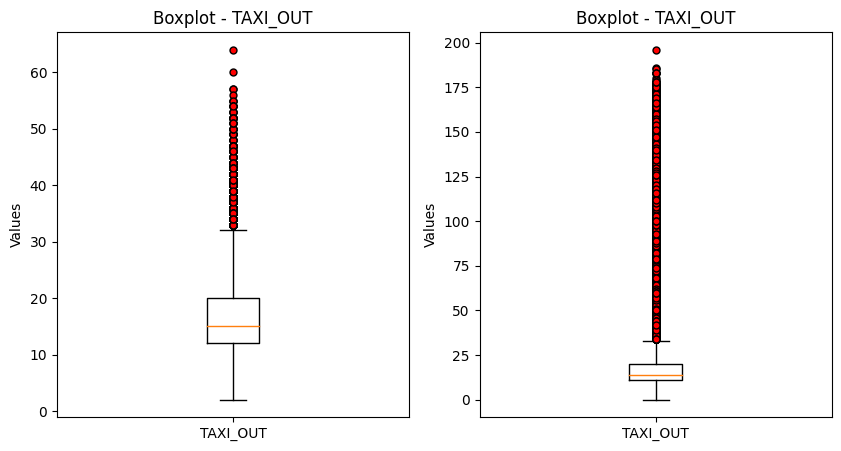

In [ ]:
plot_boxplot2(df_fixed, df_delays, 'TAXI_OUT', 'TAXI_OUT', 'Boxplot - TAXI_OUT')

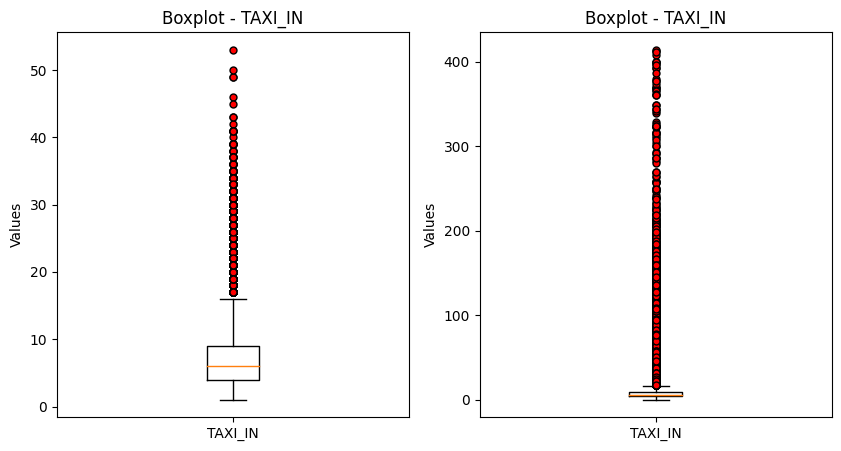

In [ ]:
plot_boxplot2(df_fixed, df_delays, 'TAXI_IN', 'TAXI_IN', 'Boxplot - TAXI_IN')

For TAXI_IN and TAXI_OUT we have a large number of outliers above the upper whisker.

We can see that for flights that did not have any delay and delayed flights the scaling of the boxplots is completely different for both TAXI_IN and TAXI_OUT. For TAXI_OUT, delayed flights' maximum is around 200, while for flights done on schedule is around 60. Since the two medians are relatively close, around 15, we have a much larger number of outliers for delayed flights. This is also the case for TAXI_IN, as the maximum values for delayed and non-delayed flights are around 400 and 55 respectively.

As for TAXI_OUT and TAXI_IN, considering their medians, we have that generally the time duration elapsed between departure from the origin airport gate and wheels off than the time duration elapsed between wheels-on and gate arrival at the destination airport. 

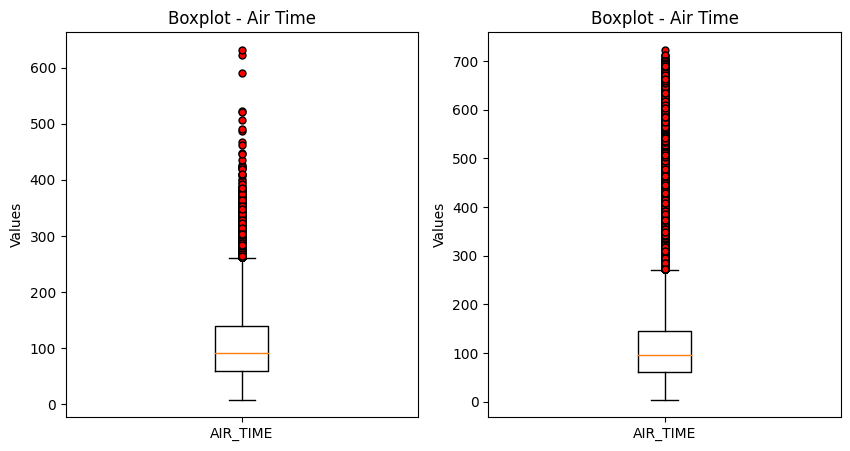

In [ ]:
plot_boxplot2(df_fixed, df_delays, 'AIR_TIME', 'AIR_TIME', 'Boxplot - Air Time')

For AIR_TIME, we have outliers only above the upper whisker and again for delayed flights the number outliers is higher than that of non-delayed flights.

# **3. Exploratory Data Analysis**

## 3.1. Distribution of Flights

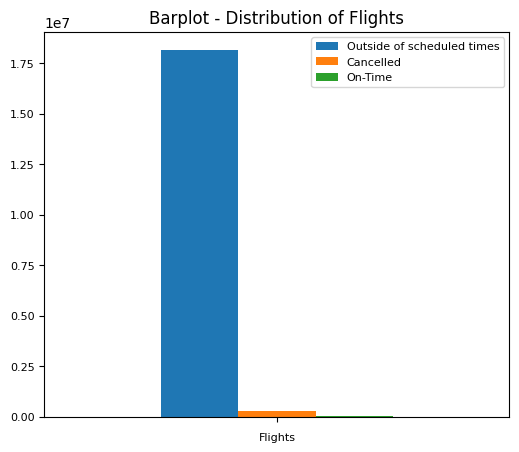

In [ ]:
# create a pandas dataframe in order to illustrate the flights into a barplot
data = {'Outside of scheduled times': [num_delays],
        'Cancelled': [num_cancel],
        'On-Time' : num_fixed}
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=8)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=8)
ax.set_title('Barplot - Distribution of Flights')
plt.show()

It is clearly evident that the vast majority of the flights of our dataset were non-typical flights, i.e., flights that have taken place outside of the scheduled times, either the departure, or/and the arrival.

## 3.2. Compare Early and Delayed Flights

In [ ]:
# df1
# delays dataframe (include negative values of DEP_DELAY and ARR_DELAY as delays as well)
df1_delays = df1.filter(((df1.DEP_DELAY != 0) | (df1.ARR_DELAY != 0)))

# flights done based on the schedule - not cancelled & no delays
df1_fixed = df1.filter((df1.DEP_DELAY == 0) & (df1.ARR_DELAY == 0))

# drop unnecessary columns
df1_fixed = df1_fixed.drop('DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY')


# similarly for df2 and df3
df2_delays = df2.filter(((df2.DEP_DELAY != 0) | (df2.ARR_DELAY != 0)))
df2_fixed = df2.filter((df2.DEP_DELAY == 0) & (df2.ARR_DELAY == 0))
df2_fixed = df2_fixed.drop('DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY')

df3_delays = df3.filter(((df3.DEP_DELAY != 0) | (df3.ARR_DELAY != 0)))
df3_fixed = df3.filter((df3.DEP_DELAY == 0) & (df3.ARR_DELAY == 0))
df3_fixed = df3_fixed.drop('DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY')

### 3.2.1. Departure

In [ ]:
num_DEP_delays = df_delays.filter(df.DEP_DELAY > 0).count()
num_DEP_early = df_delays.filter(df.DEP_DELAY < 0).count()

In [ ]:
# delayed flights
print('Total delayed flights:', num_DEP_delays)
print('Delayed flights in 2016:', df1_delays.filter(df1.DEP_DELAY > 0).count())
print('Delayed flights in 2017:', df2_delays.filter(df2.DEP_DELAY > 0).count())
print('Delayed flights in 2018:', df3_delays.filter(df3.DEP_DELAY > 0).count())

# early flights
print('Total early flights:', num_DEP_early)
print('Early flights in 2016:', df1_delays.filter(df1.DEP_DELAY < 0).count())
print('Early flights in 2017:', df2_delays.filter(df2.DEP_DELAY < 0).count())
print('Early flights in 2018:', df3_delays.filter(df3.DEP_DELAY < 0).count())

Total delayed flights: 6289969
Delayed flights in 2016: 1912740
Delayed flights in 2017: 1940179
Delayed flights in 2018: 2437049
Total early flights: 10956138
Early flights in 2016: 3317312
Early flights in 2017: 3354727
Early flights in 2018: 4284099


* Considering that the observations of 2018 are more than the data of the years 2016 and 2017 we cannot conclude to the idea that the delayed or early departure flights increased.
* The phenomenon for a departure flight to take place earlier than the schedule is more common rather to start later, whereas a small percentage of flights were on time and an even smaller one cancelled. [Total of departure flights done based on the schedule: 943265, whereas the overall fixed flights, ie flights based on the schedule (both departure AND arrival) are 29511, hence we have 913754 flights which were done out of the arrival time (either earlier or later) but the airport departured on time]

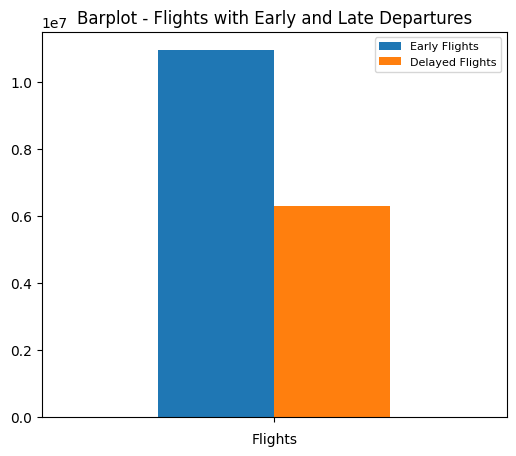

In [ ]:
# create a pandas dataframe in order to illustrate the flights into a barplot

data = {'Early Flights': [num_DEP_early],
        'Delayed Flights': [num_DEP_delays]
        }
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=10)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=10)
ax.set_title('Barplot - Flights with Early and Late Departures')
plt.show()

### 3.2.2. Arrival 

In [ ]:
num_ARR_delays = df_delays.filter(df.ARR_DELAY > 0).count()
num_ARR_early = df_delays.filter(df.ARR_DELAY < 0).count()

In [ ]:
# delayed flights
print('Total delayed flights:', num_ARR_delays)
print('Delayed flights in 2016:', df1_delays.filter(df1.ARR_DELAY > 0).count())
print('Delayed flights in 2017:', df2_delays.filter(df2.ARR_DELAY > 0).count())
print('Delayed flights in 2018:', df3_delays.filter(df3.ARR_DELAY > 0).count())

# early flights
print('Total early flights:', num_ARR_early)
print('Early flights in 2016:', df1_delays.filter(df1.ARR_DELAY < 0).count())
print('Early flights in 2017:', df2_delays.filter(df2.ARR_DELAY < 0).count())
print('Early flights in 2018:', df3_delays.filter(df3.ARR_DELAY < 0).count())

Total delayed flights: 6344184
Delayed flights in 2016: 1884785
Delayed flights in 2017: 1944547
Delayed flights in 2018: 2514851
Total early flights: 11478462
Early flights in 2016: 3537497
Early flights in 2017: 3523217
Early flights in 2018: 4417748


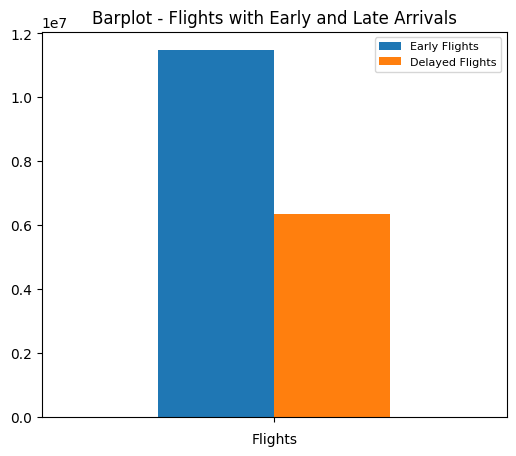

In [ ]:
# create a pandas dataframe in order to illustrate the flights into a barplot

data = {'Early Flights': [num_ARR_early],
        'Delayed Flights': [num_ARR_delays]
        }
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=10)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=10)
ax.set_title('Barplot - Flights with Early and Late Arrivals')
plt.show()

* We have more delayed and early flights at the arrival airports than the origin ones.
* Similarly, the early arrival flights are more than the arrival delays.

## 3.3. Distribution of Departure and Arrival Delay

In [ ]:
df_delays_pd = df_delays.select('DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DISTANCE').toPandas()

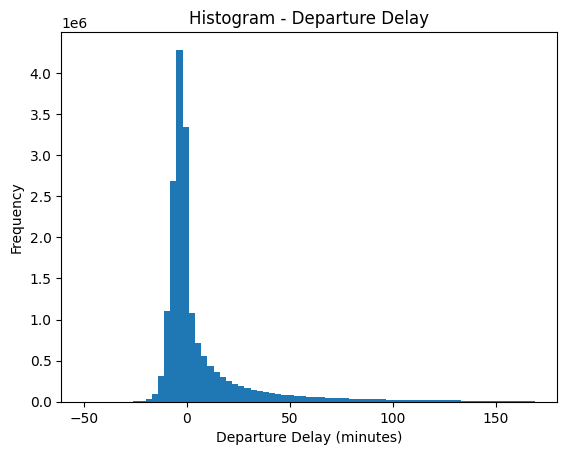

In [ ]:
bin_size = 3
plt.hist(df_delays_pd['DEP_DELAY'], bins=range(-50, 170,bin_size))

plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram - Departure Delay')
plt.show()

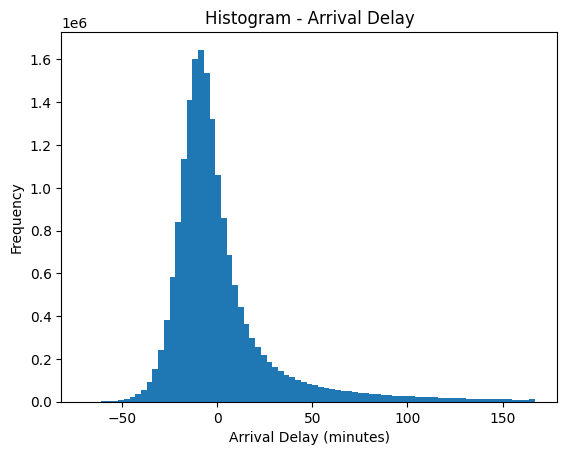

In [ ]:
bin_size = 3
plt.hist(df_delays_pd['ARR_DELAY'], bins=range(-70, 170,bin_size))

plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram - Arrival Delay')
plt.show()

In the above plots 'departure delay' and 'arrival delay' we can observe that in our data the most of our delays is less than 1 hour, and the most flighs have zero delay. the only different the arrival delays have more times early arrival compare to early depanture delays, this is interesting because some times maybe the flight can start on time and for some reason to get on the destination early.

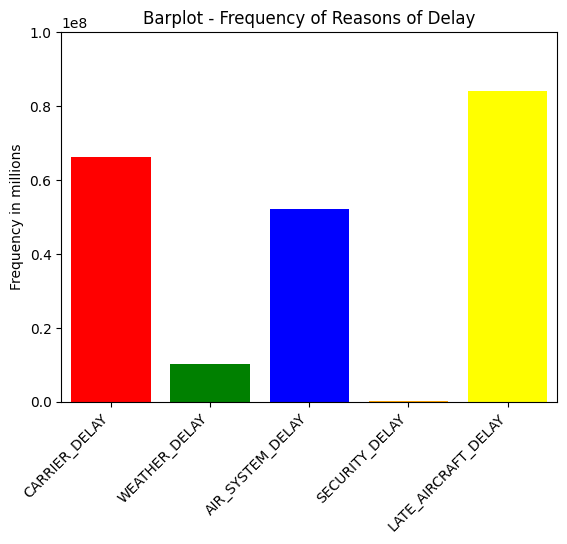

In [ ]:
# Compute the frequency for each variable
freqs = [df_delays_pd['CARRIER_DELAY'].sum(),df_delays_pd['WEATHER_DELAY'].sum(),
         df_delays_pd['NAS_DELAY'].sum(),df_delays_pd['SECURITY_DELAY'].sum(),
         df_delays_pd['LATE_AIRCRAFT_DELAY'].sum()]

fig, ax = plt.subplots()
x_labels = ['CARRIER_DELAY', 'WEATHER_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
x_pos = [i for i in range(len(x_labels))]

colors = ['red', 'green', 'blue', 'orange', 'yellow']

ax.bar(x_pos, freqs,color=colors)

ax.set_ylabel('Frequency in millions')
plt.ylim(0,100000000)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_xlim(-0.5, 4.5)

plt.title('Barplot - Frequency of Reasons of Delay')
# Display the plot
plt.show()

In the above chart we can see the 5 different reason of the delays and the frequence of each one, as we can observe Late aircraft in the most ordinary reason for our delays then we have carrier delay , air system and the remaining are for weather and security, weather and security is very diffuclt to delay our flight as it have to be something very extremly or extremly weather or something with the security

## 3.4. Explore Departure and Arrival Delay per Airport

### 3.4.1. Delayed Flights

In [ ]:
# only positive delays
df_delaysPos = df_delays.filter((df.DEP_DELAY > 0) | (df.ARR_DELAY > 0))

In [ ]:
df_delaysPos = df_delaysPos.select('ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY').toPandas()

360

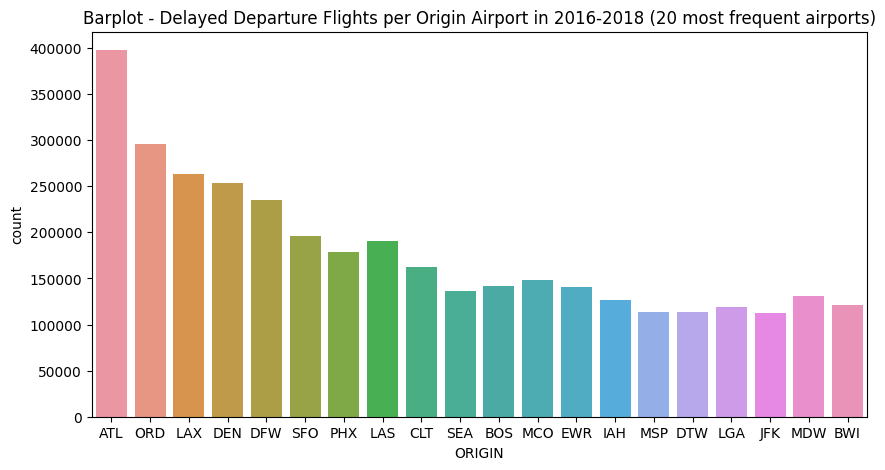

In [ ]:
# the 20 most frequent departure airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df_delaysPos[
    df_delaysPos.DEP_DELAY >0 # take only delays occured in departure airport
    ]['ORIGIN'], order=df_delaysPos.ORIGIN.value_counts().iloc[:20].index )
ax.set_title('Barplot - Delayed Departure Flights per Origin Airport in 2016-2018 (20 most frequent airports)')
df_delaysPos.ORIGIN.nunique()

359

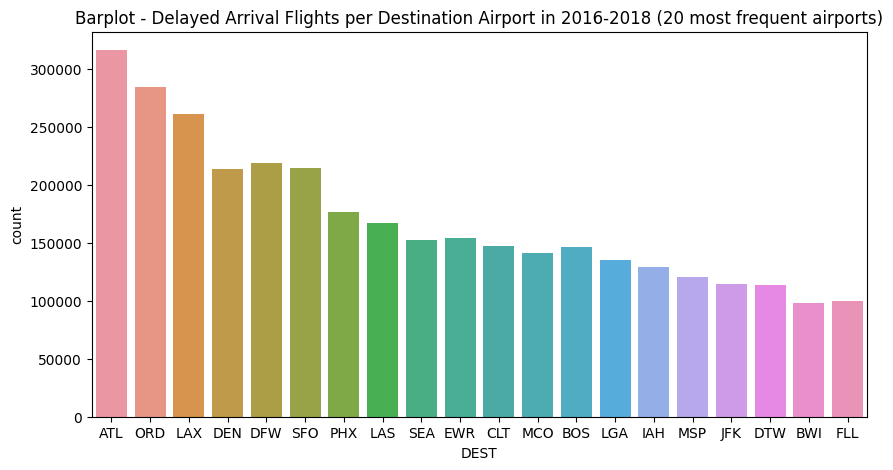

In [ ]:
# the 20 most frequent arrival airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df_delaysPos[
    df_delaysPos.ARR_DELAY >0][ # take only delays happend in arrival airports
        'DEST'], order=df_delaysPos.DEST.value_counts().iloc[:20].index )
ax.set_title('Barplot - Delayed Arrival Flights per Destination Airport in 2016-2018 (20 most frequent airports)')
df_delaysPos.DEST.nunique()

In general, the number of flights that had delayed departure is slightly less than that had a late arrival. However, for the first airport (with the most of delays), that is ATL, the departure delays that are approximately 11,000 are way more than the arrival delays that are around 8,200.

In [ ]:
# only negative "delays" in departure airport (early flights)
df_delaysNegORIGIN = df_delays.filter((df.DEP_DELAY < 0))

# there are too many observations, hence the df_delaysNegORIGIN cannot transformed into Pandas dataframe
rdd_delaysNegORIGIN = df_delaysNegORIGIN.select('ORIGIN').rdd

In [ ]:
rdd_delaysNegORIGIN = rdd_delaysNegORIGIN.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)
rdd_delaysNegORIGIN.sortBy(lambda x: -x[1]).take(20)

[(Row(ORIGIN='ATL'), 12387),
 (Row(ORIGIN='DFW'), 7931),
 (Row(ORIGIN='ORD'), 7826),
 (Row(ORIGIN='DEN'), 6687),
 (Row(ORIGIN='LAX'), 6320),
 (Row(ORIGIN='PHX'), 5963),
 (Row(ORIGIN='IAH'), 5609),
 (Row(ORIGIN='SFO'), 5380),
 (Row(ORIGIN='CLT'), 4859),
 (Row(ORIGIN='SEA'), 4751),
 (Row(ORIGIN='MSP'), 4747),
 (Row(ORIGIN='LAS'), 4682),
 (Row(ORIGIN='DTW'), 4551),
 (Row(ORIGIN='MCO'), 4042),
 (Row(ORIGIN='SLC'), 3934),
 (Row(ORIGIN='LGA'), 3542),
 (Row(ORIGIN='DCA'), 3433),
 (Row(ORIGIN='BOS'), 3389),
 (Row(ORIGIN='EWR'), 2967),
 (Row(ORIGIN='TPA'), 2754)]

Although the airport ATL has the most cases of delay (both departure and arrival delay), it also has the most cases of early flights. More specifically early departure flights are 12387, which means that they are than the delayed ones. This happens probably due to the fact that the overall early flights are more than the delayed ones (section 3.3).

### 3.4.2. Early Flights

Due to the extensive computation time required to process the entire dataframe, we decided to run the barplots for early flights separately for each distinct year (2016, 2017, 2018). This partitioning strategy not only reduces the overall processing time, but also facilitates more manageable data handling and analysis.

------ **2016** ------

In [ ]:
# only negative "delays" in departure airport (early flights)
df1_delaysNeg = df1_delays.filter((df1.DEP_DELAY < 0) | (df1.ARR_DELAY < 0))

df1_delaysNeg = df1_delaysNeg.select('ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY').toPandas()

309

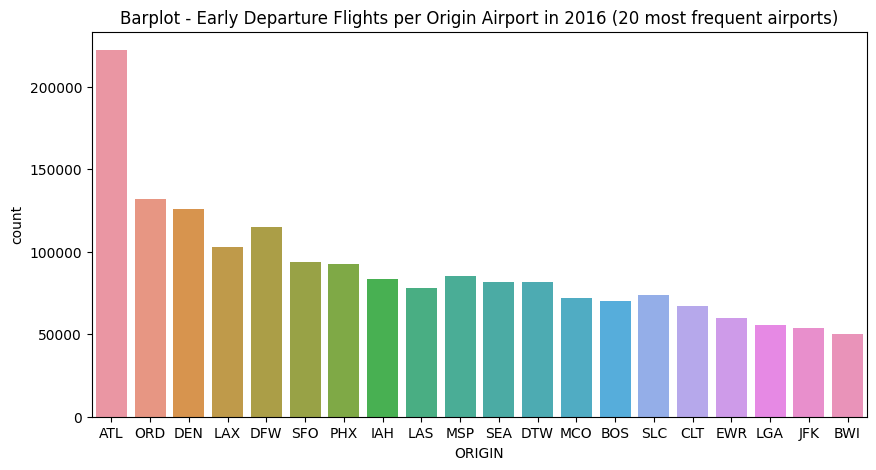

In [ ]:
# the 20 most frequent departure airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df1_delaysNeg[df1_delaysNeg.DEP_DELAY < 0]['ORIGIN'], order=df1_delaysNeg.ORIGIN.value_counts().iloc[:20].index )
ax.set_title('Barplot - Early Departure Flights per Origin Airport in 2016 (20 most frequent airports)')
df1_delaysNeg.ORIGIN.nunique()

310

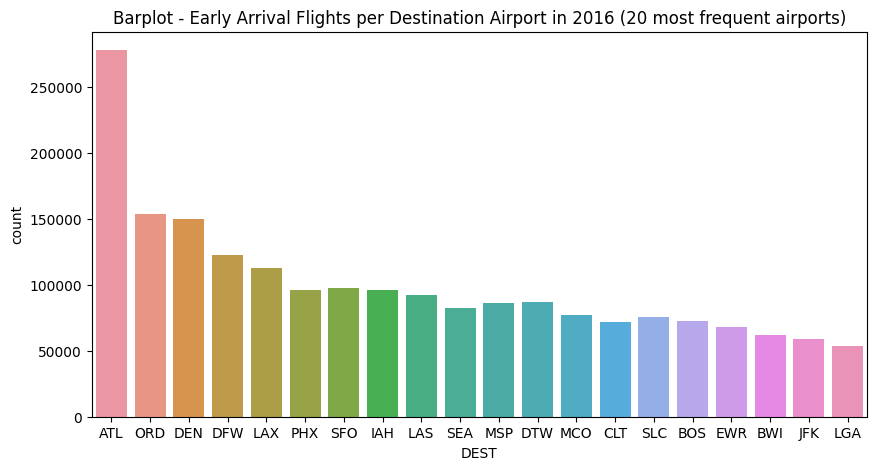

In [ ]:
# the 20 most frequent arrival airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df1_delaysNeg[
    df1_delaysNeg.ARR_DELAY <0][ # take only delays happend in arrival airports
        'DEST'], order=df1_delaysNeg.DEST.value_counts().iloc[:20].index )
ax.set_title('Barplot - Early Arrival Flights per Destination Airport in 2016 (20 most frequent airports)')
df1_delaysNeg.DEST.nunique()

------ **2017** ------

In [ ]:
# only negative "delays" in departure airport (early flights)
df2_delaysNeg = df2_delays.filter((df2.DEP_DELAY < 0) | (df2.ARR_DELAY < 0))

df2_delaysNeg = df2_delaysNeg.select('ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY').toPandas()

318

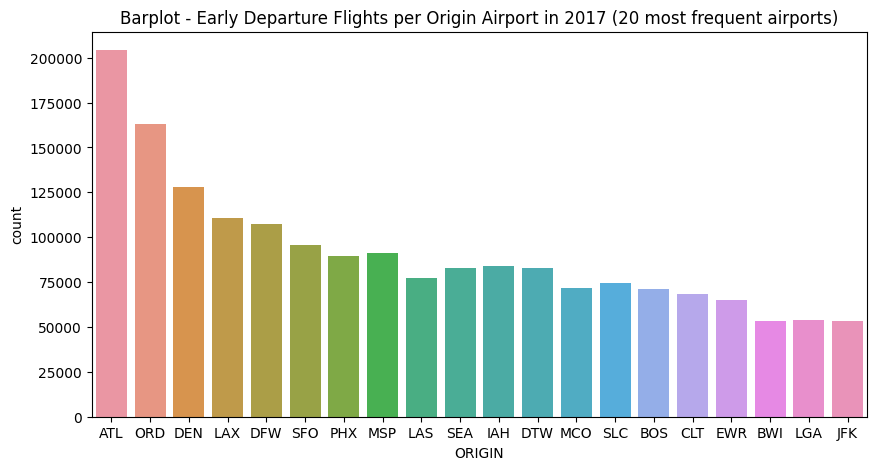

In [ ]:
# the 20 most frequent departure airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df2_delaysNeg[df2_delaysNeg.DEP_DELAY < 0]['ORIGIN'], order=df2_delaysNeg.ORIGIN.value_counts().iloc[:20].index )
ax.set_title('Barplot - Early Departure Flights per Origin Airport in 2017 (20 most frequent airports)')
df2_delaysNeg.ORIGIN.nunique()

319

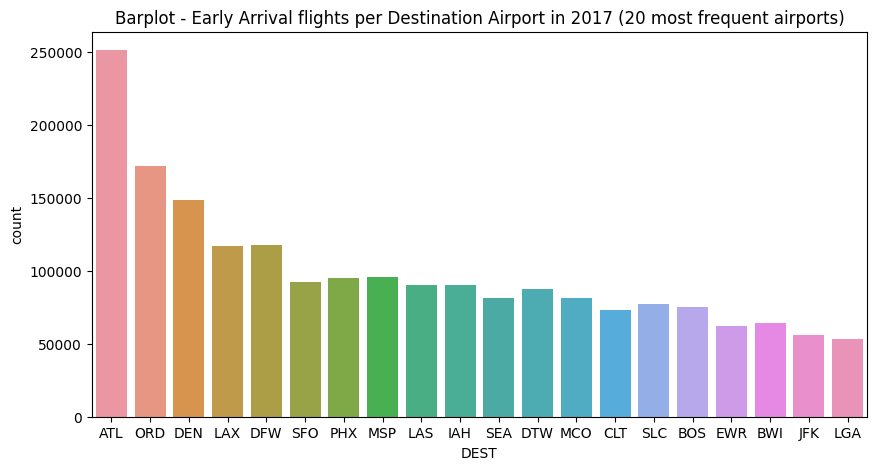

In [ ]:
# the 20 most frequent arrival airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df2_delaysNeg[
    df2_delaysNeg.ARR_DELAY <0][ # take only delays happend in arrival airports
        'DEST'], order=df2_delaysNeg.DEST.value_counts().iloc[:20].index )
ax.set_title('Barplot - Early Arrival flights per Destination Airport in 2017 (20 most frequent airports)')
df2_delaysNeg.DEST.nunique()

------ **2018** ------

In [ ]:
# only negative "delays" in departure airport (early flights)
df3_delaysNeg = df3_delays.filter((df3.DEP_DELAY < 0) | (df3.ARR_DELAY < 0))

df3_delaysNeg = df3_delaysNeg.select('ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY').toPandas()

357

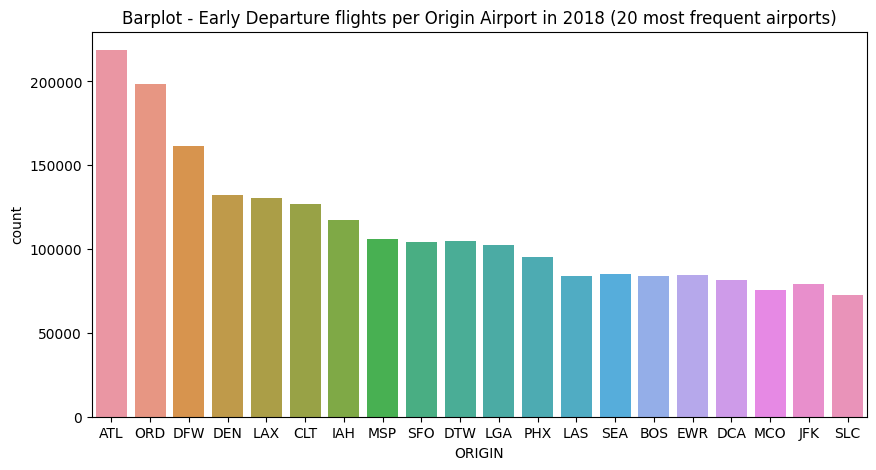

In [ ]:
# the 20 most frequent departure airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df3_delaysNeg[df3_delaysNeg.DEP_DELAY < 0]['ORIGIN'], order=df3_delaysNeg.ORIGIN.value_counts().iloc[:20].index )
ax.set_title('Barplot - Early Departure flights per Origin Airport in 2018 (20 most frequent airports)')
df3_delaysNeg.ORIGIN.nunique()

357

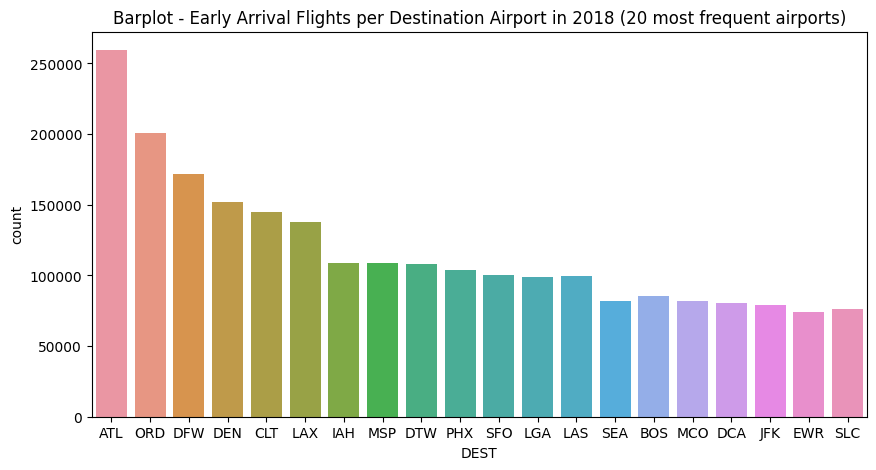

In [ ]:
# the 20 most frequent arrival airports
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df3_delaysNeg[
    df3_delaysNeg.ARR_DELAY <0][ # take only delays happend in arrival airports
        'DEST'], order=df3_delaysNeg.DEST.value_counts().iloc[:20].index )
ax.set_title('Barplot - Early Arrival Flights per Destination Airport in 2018 (20 most frequent airports)')
df3_delaysNeg.DEST.nunique()

First of all, considering the unique values of the departure and arrival airports, we can see that in 2016 and 2017 there was 1 airport from where did not taken place any departure flights, only arrival ones.

Concerning the first of the barplots airports we can see a large difference between the count of early flights of the 1st and the other ones during 2016 and 2017. In 2018 we can observe that this significant difference decreases.



## 3.5. Explore Departure and Arrival Delay per Month, Weekday and Time of the Day

In [ ]:
# convert the data type of FL_DATE
df = df.withColumn('FL_DATE', col('FL_DATE').cast('date'))
df1 = df1.withColumn('FL_DATE', col('FL_DATE').cast('date'))
df2 = df2.withColumn('FL_DATE', col('FL_DATE').cast('date'))
df3 = df3.withColumn('FL_DATE', col('FL_DATE').cast('date'))

In [ ]:
df = df.withColumn('Day', f.date_format('FL_DATE', 'EE'))
df1 = df1.withColumn('Day', f.date_format('FL_DATE', 'EE'))
df2 = df2.withColumn('Day', f.date_format('FL_DATE', 'EE'))
df3 = df3.withColumn('Day', f.date_format('FL_DATE', 'EE'))
df = df.withColumn('Month', month('FL_DATE'))
df1 = df1.withColumn('Month', month('FL_DATE'))
df2 = df2.withColumn('Month', month('FL_DATE'))
df3 = df3.withColumn('Month', month('FL_DATE'))
df = df.withColumn('Year', year('FL_DATE'))
df1 = df1.withColumn('Year', year('FL_DATE'))
df2 = df2.withColumn('Year', year('FL_DATE'))
df3 = df3.withColumn('Year', year('FL_DATE'))

### 3.5.1. Departure Delay

#### 3.5.1.1. Departure Delay per Month

In [ ]:
df_delays_ORIGIN = df.filter(df.DEP_DELAY > 0)
print('Number of delayed departure flights per month in 2016-2018')
df_delays_ORIGIN.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Number of delayed departure flights per month in 2016-2018


[(Row(Month=7), 641780),
 (Row(Month=6), 620803),
 (Row(Month=8), 611330),
 (Row(Month=12), 561363),
 (Row(Month=5), 549130),
 (Row(Month=3), 529249),
 (Row(Month=1), 499340),
 (Row(Month=4), 496386),
 (Row(Month=10), 473033),
 (Row(Month=11), 459054),
 (Row(Month=2), 424982),
 (Row(Month=9), 423518)]

Text(0.5, 1.0, 'Barplot - Departure Delay per Month in 2016-2018')

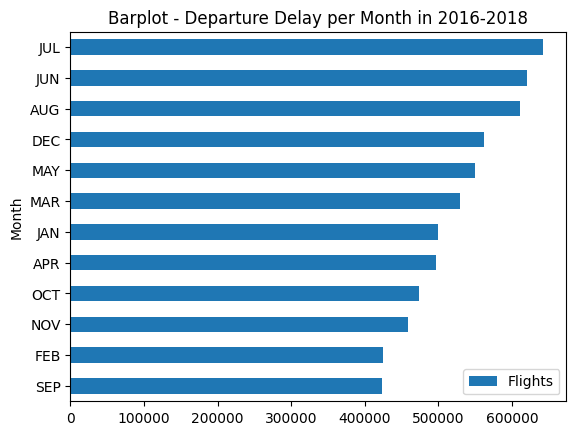

In [ ]:
# create manually (to save computation time) a pandas df to create a barplot 

data = pd.DataFrame({'Month':['JAN', 'FEB', 'MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'], 'Flights':[499340, 424982, 529249,496386,549130,620803,641780,611330,423518,473034,459054,561363]})
data = data.sort_values(by=['Flights'])
ax = data.plot.barh(x='Month', y='Flights')
ax.set_title("Barplot - Departure Delay per Month in 2016-2018")

#### 3.5.1.2. Departure Delay per Weekday

In [ ]:
print('Number of delayed departure flights per weekday in 2016-2018')
df_delays_ORIGIN.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Number of delayed departure flights per weekday in 2016-2018


[(Row(Day='Fri'), 1026071),
 (Row(Day='Thu'), 990496),
 (Row(Day='Mon'), 960870),
 (Row(Day='Sun'), 881806),
 (Row(Day='Wed'), 866533),
 (Row(Day='Tue'), 846681),
 (Row(Day='Sat'), 717511)]

Text(0.5, 1.0, 'Barplot - Departure Delay per Weekday in 2016-2018')

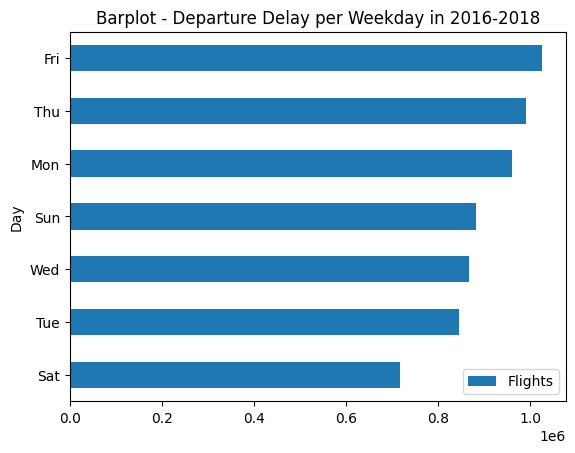

In [ ]:
# create manually (to save computation time) a pandas df to create a barplot 
data = pd.DataFrame({'Day':['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], 'Flights':[960870, 846682,866533,990496,1026071,717511,881806]})
data = data.sort_values(by=['Flights'])
ax = data.plot.barh(x='Day', y='Flights')
ax.set_title("Barplot - Departure Delay per Weekday in 2016-2018")

#### 3.5.1.3. Departure Delay per Time of the Day

In [ ]:
# count delayed flights per time of the day
num_night =df_delays_ORIGIN.filter((0 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 600)).count()
num_morning = df_delays_ORIGIN.filter((600 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 1200)).count()
num_afternoon = df_delays_ORIGIN.filter((1200 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 1800)).count()
num_evening = df_delays_ORIGIN.filter((1800 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')<= 2359)).count()

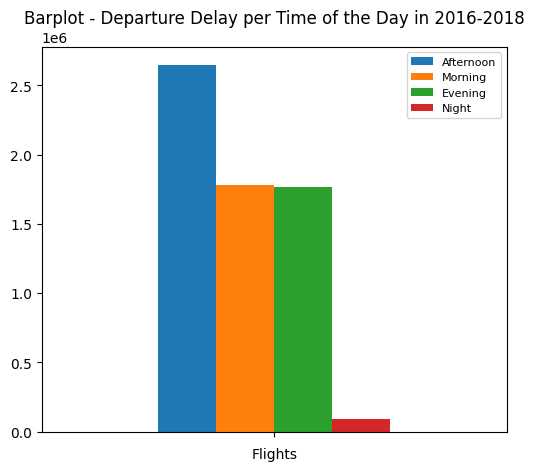

In [ ]:
# create pandas df for departure time

data = {'Afternoon': [num_afternoon],
        'Morning': [num_morning],
        'Evening': [num_evening],  
        'Night': [num_night]
}
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=10)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=10)
ax.set_title("Barplot - Departure Delay per Time of the Day in 2016-2018")
plt.show()

Here we can see that in afternoon we have the most of delayed departure flights whereas we have negligible amount of delays during the night. However, we cannot conclude to a clear statement since we do not know the overall data.

Below, we can illustrate how the total data are distributed into the periods of day.

In [ ]:
num_night =df.filter((0 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 600)).count()
num_morning = df.filter((600 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 1200)).count()
num_afternoon = df.filter((1200 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 1800)).count()
num_evening = df.filter((1800 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')<= 2359)).count()

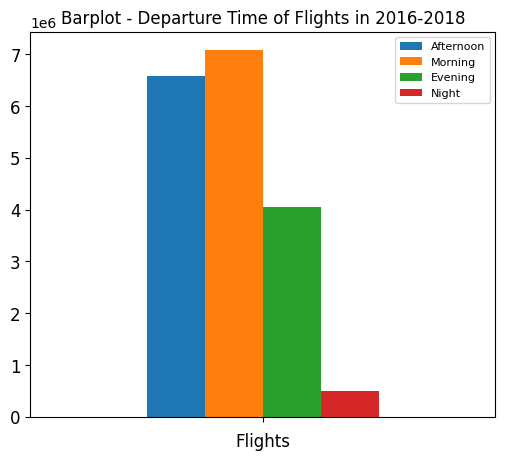

In [ ]:
# create pandas df for departure time of flights

data = {'Afternoon': [num_afternoon],
        'Morning': [num_morning],
        'Evening': [num_evening],  
        'Night': [num_night]
}
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=12)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=12)
ax.set_title("Barplot - Departure Time of Flights in 2016-2018")
plt.show()

At first glance we can observe the following:

* just over 40% of the afternoon flights delayed
* about 25% of the morning flights delayed
* just under 45% of the evening flights delayed
* 20% of the night flights delayed

Thus, we can forecast that the CRS_DEP_TIME plays a role for the delay on the origin airport.



#### Differences per year 2016-2018

------ **2016** ------

In [ ]:
df1_delays_ORIGIN = df1.filter(df1.DEP_DELAY > 0)
print('Delayed flights from starting airport in 2016 based on months\n')
df1_delays_ORIGIN.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights from starting airport in 2016 based on months



[(Row(Month=7), 200890),
 (Row(Month=12), 191985),
 (Row(Month=6), 187151),
 (Row(Month=8), 185954),
 (Row(Month=3), 163092),
 (Row(Month=5), 158410),
 (Row(Month=1), 148666),
 (Row(Month=4), 141211),
 (Row(Month=10), 141084),
 (Row(Month=11), 133705),
 (Row(Month=9), 132895),
 (Row(Month=2), 127697)]

In [ ]:
print('Delayed flights from starting airport in 2016 based on days\n')
df1_delays_ORIGIN.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights from starting airport in 2016 based on days



[(Row(Day='Sun'), 13828),
 (Row(Day='Sat'), 10408),
 (Row(Day='Fri'), 10260),
 (Row(Day='Mon'), 9756),
 (Row(Day='Tue'), 6193),
 (Row(Day='Wed'), 5333),
 (Row(Day='Thu'), 5062)]

------ **2017** ------

In [ ]:
df2_delays_ORIGIN = df2.filter(df2.DEP_DELAY > 0)
print('Delayed flights from starting airport in 2017 based on months\n')
df2_delays_ORIGIN.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights from starting airport in 2017 based on months



[(Row(Month=6), 196660),
 (Row(Month=7), 196020),
 (Row(Month=8), 187679),
 (Row(Month=5), 176564),
 (Row(Month=1), 167834),
 (Row(Month=12), 167785),
 (Row(Month=3), 167106),
 (Row(Month=4), 162750),
 (Row(Month=10), 145431),
 (Row(Month=11), 124843),
 (Row(Month=9), 124219),
 (Row(Month=2), 123288)]

In [ ]:
print('Delayed flights from starting airport in 2017 based on days\n')
df2_delays_ORIGIN.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights from starting airport in 2017 based on days



[(Row(Day='Mon'), 17212),
 (Row(Day='Sun'), 13969),
 (Row(Day='Tue'), 8746),
 (Row(Day='Thu'), 7342),
 (Row(Day='Fri'), 7275),
 (Row(Day='Wed'), 6813),
 (Row(Day='Sat'), 6700)]

------ **2018** ------

In [ ]:
df3_delays_ORIGIN = df3.filter(df3.DEP_DELAY > 0)
print('Delayed flights from starting airport in 2018 based on months\n')
df3_delays_ORIGIN.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights from starting airport in 2018 based on months



[(Row(Month=1), 62814)]

In [ ]:
print('Delayed flights from starting airport in 2018 based on days\n')
df3_delays_ORIGIN.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights from starting airport in 2018 based on days



[(Row(Day='Mon'), 15757),
 (Row(Day='Tue'), 9826),
 (Row(Day='Wed'), 8654),
 (Row(Day='Sun'), 8553),
 (Row(Day='Fri'), 7690),
 (Row(Day='Sat'), 6649),
 (Row(Day='Thu'), 5685)]

* We have the most of departure delays during the summer, appart from the year 2016, where we had a large number of delayed flights in December as well.
* There is about a difference of 10000 delayed departure flights between days, apart from Saturdays which have quite less delays than the rest ones. More specifically, Fridays, Thursdays and Mondays are the days with the most of delays.

### 3.5.2 Arrival delay

#### 3.5.2.1. Arrival Delay per Month

In [ ]:
df_delays_DEST = df.filter(df.ARR_DELAY > 0)
print('Number of delayed arrival flights per month in 2016-2018')
df_delays_DEST.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2016-2018 based on months


[(Row(Month=7), 635206),
 (Row(Month=8), 620275),
 (Row(Month=6), 617080),
 (Row(Month=12), 555023),
 (Row(Month=5), 552048),
 (Row(Month=3), 538017),
 (Row(Month=4), 510151),
 (Row(Month=1), 493675),
 (Row(Month=10), 493231),
 (Row(Month=11), 459059),
 (Row(Month=9), 442825),
 (Row(Month=2), 427594)]

Text(0.5, 1.0, 'Barplot - Arrival Delay per Month in 2016-2018')

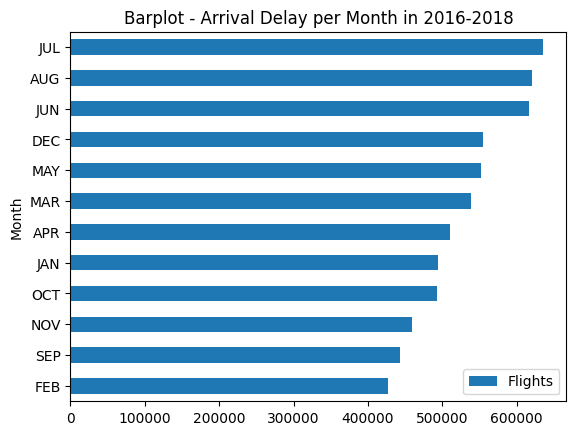

In [ ]:
# create manually (to save computation time) a pandas df to create a barplot 

data = pd.DataFrame({'Month':['JAN', 'FEB', 'MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'], 'Flights':[493675,427594,538017,510151,552048,617080,635206,620275,442825,493231,459059,555023]})
data = data.sort_values(by=['Flights'])
ax = data.plot.barh(x='Month', y='Flights')
ax.set_title("Barplot - Arrival Delay per Month in 2016-2018")

#### 3.5.2.2. Arrival Delay per Weekday

In [ ]:
print('Number of delayed arrival flights per weekday in 2016-2018')
df_delays_DEST.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2016-2018 based on days


[(Row(Day='Fri'), 1039070),
 (Row(Day='Thu'), 1015890),
 (Row(Day='Mon'), 969921),
 (Row(Day='Wed'), 893783),
 (Row(Day='Tue'), 871336),
 (Row(Day='Sun'), 865503),
 (Row(Day='Sat'), 688681)]

Text(0.5, 1.0, 'Barplot - Arrival Delay per Weekday in 2016-2018')

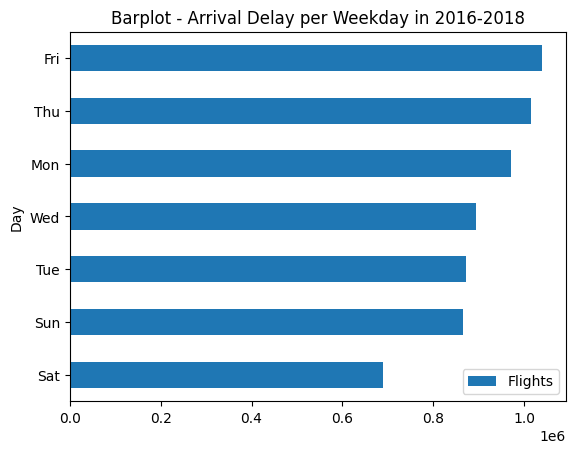

In [ ]:
# create manually (to save computation time) a pandas df to create a barplot 

data = pd.DataFrame({'Day':['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'], 'Flights':[969921,871336,893783,1015890,1039070,688681,865503]})
data = data.sort_values(by=['Flights'])
ax = data.plot.barh(x='Day', y='Flights')
ax.set_title("Barplot - Arrival Delay per Weekday in 2016-2018")

#### 3.5.2.3. Arrival Delay per Time of the Day

In [ ]:
# count delayed flights per time of the day
num_night =df_delays_ORIGIN.filter((0 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 600)).count()
num_morning = df_delays_ORIGIN.filter((600 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 1200)).count()
num_afternoon = df_delays_ORIGIN.filter((1200 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 1800)).count()
num_evening = df_delays_ORIGIN.filter((1800 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')<= 2359)).count()

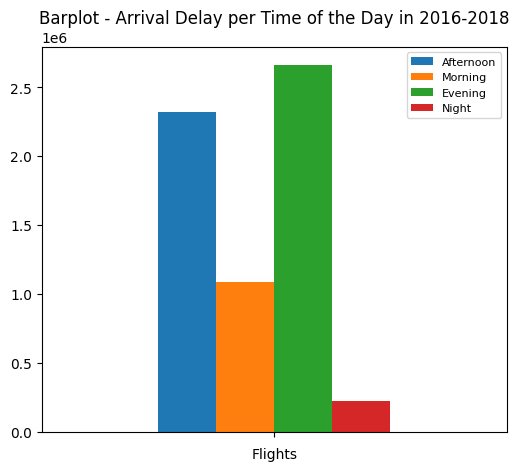

In [ ]:
# create pandas df for arrival time

data = {'Afternoon': [num_afternoon],
        'Morning': [num_morning],
        'Evening': [num_evening],  
        'Night': [num_night]
}
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=10)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=10)
ax.set_title("Barplot - Arrival Delay per Time of the Day in 2016-2018")
plt.show()

In [ ]:
num_night =df.filter((0 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 600)).count()
num_morning = df.filter((600 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 1200)).count()
num_afternoon = df.filter((1200 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 1800)).count()
num_evening = df.filter((1800 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')<= 2359)).count()

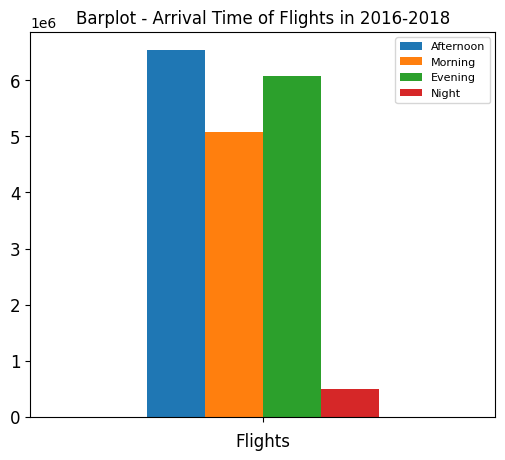

In [ ]:
# create pandas df for departure time of flights

data = {'Afternoon': [num_afternoon],
        'Morning': [num_morning],
        'Evening': [num_evening],  
        'Night': [num_night]
}
  
data = pd.DataFrame(data) 
ax = data.plot(kind='bar', figsize=(6,5), fontsize=12)
ax.set(xticklabels=[])
ax.legend(fontsize=8)
ax.set_xlabel("Flights",fontsize=12)
ax.set_title("Barplot - Arrival Time of Flights in 2016-2018")
plt.show()

#### Differences per year 2016-2018

------ **2016** ------

In [ ]:
df1_delays_DEST = df1.filter(df1.ARR_DELAY > 0)
print('Delayed flights at destination airport in 2016 based on months\n')
df1_delays_DEST.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2016 based on months



[(Row(Month=1), 54318)]

In [ ]:
print('Delayed flights at destination airport in 2016 based on days\n')
df1_delays_DEST.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2016 based on days



[(Row(Day='Sun'), 12554),
 (Row(Day='Fri'), 9627),
 (Row(Day='Sat'), 8856),
 (Row(Day='Mon'), 8534),
 (Row(Day='Tue'), 5207),
 (Row(Day='Wed'), 4792),
 (Row(Day='Thu'), 4748)]

------ **2017** ------

In [ ]:
df2_delays_DEST = df2.filter(df2.ARR_DELAY > 0)
print('Delayed flights at destination airport in 2017 based on months\n')
df2_delays_DEST.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2017 based on months



[(Row(Month=1), 67726)]

In [ ]:
print('Delayed flights at destination airport in 2017 based on days\n')
df2_delays_DEST.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2017 based on days



[(Row(Day='Mon'), 17353),
 (Row(Day='Sun'), 13058),
 (Row(Day='Tue'), 8682),
 (Row(Day='Thu'), 7576),
 (Row(Day='Fri'), 7465),
 (Row(Day='Sat'), 6876),
 (Row(Day='Wed'), 6716)]

------ **2018** ------

In [ ]:
df3_delays_DEST = df3.filter(df3.ARR_DELAY > 0)
print('Delayed flights at destination airport in 2018 based on months\n')
df3_delays_DEST.select('Month').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2018 based on months



[(Row(Month=1), 56600)]

In [ ]:
print('Delayed flights at destination airport in 2018 based on days\n')
df3_delays_DEST.select('Day').rdd.map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()

Delayed flights at destination airport in 2018 based on days



[(Row(Day='Mon'), 14705),
 (Row(Day='Tue'), 8965),
 (Row(Day='Wed'), 7753),
 (Row(Day='Sun'), 7491),
 (Row(Day='Fri'), 6975),
 (Row(Day='Sat'), 5656),
 (Row(Day='Thu'), 5055)]

## 3.6. Correlation between Continuous Variables

In [ ]:
df_dep_arr = df.select('DEP_DELAY', 'ARR_DELAY').toPandas()

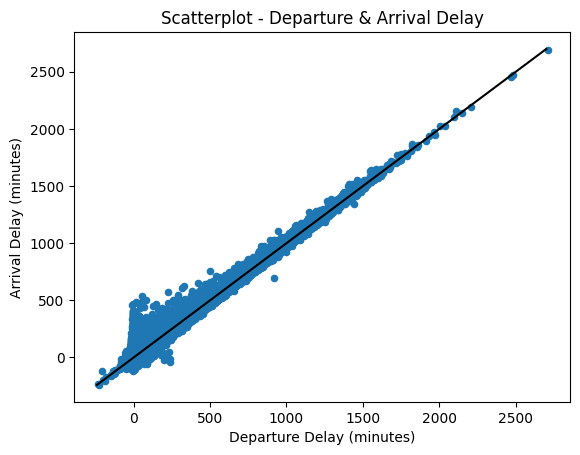

In [ ]:
df_dep_arr.plot.scatter(x = 'DEP_DELAY', y = 'ARR_DELAY')
plt.title('Scatterplot - Departure & Arrival Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.plot([-240, 2700], [-240, 2700], color='black', linestyle='-')
plt.show()

By the time we can observe that the dep_delay increases, as well as the arr_delay. Also, in all years there are cases where although we do not have arr_delay we have dep_delay and vice versa (the latter one is more rare). More specifically, this phenomenon occured many times in 2018; a lot of flights delayed during departure, but they arrived on time. 

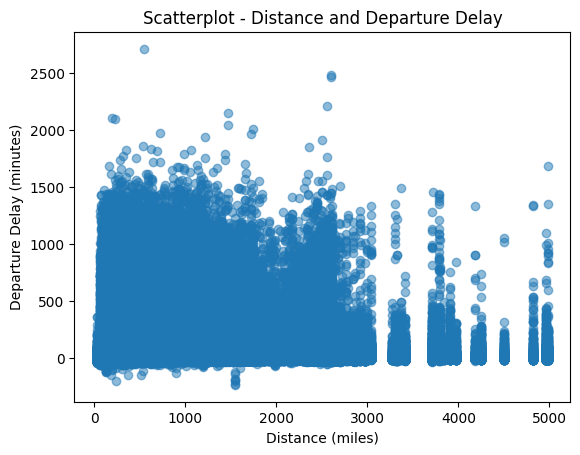

In [ ]:
# extract distance and departure delay data
distance = df_delays_pd['DISTANCE']
delay = df_delays_pd['DEP_DELAY']

fig, ax = plt.subplots()
ax.scatter(distance, delay, alpha=0.5)
ax.set_title('Scatterplot - Distance and Departure Delay')
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Departure Delay (minutes)')
plt.show()

In the above scater plot we want to compare the distance with the delay to check if the distance can occure problems with the delays, but we can observe that this is random duration dont explain the delay that much.

## 3.7. Explore Cancelled Flights

In [ ]:
df_cancel_pd = df_cancel.toPandas()

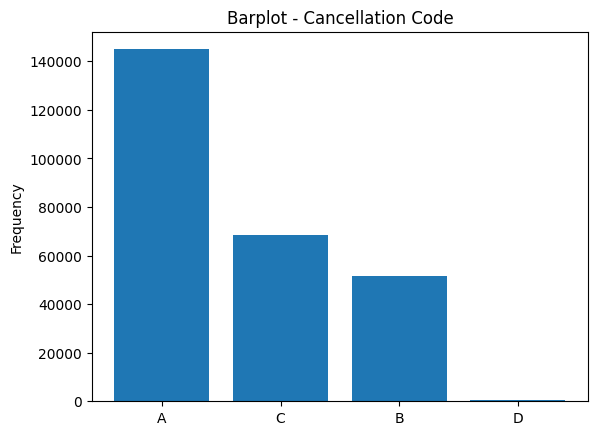

In [ ]:
filtered_df = df_cancel_pd.loc[df_cancel_pd['CANCELLATION_CODE'] != 'NO_CANCELLATION']
x = filtered_df['CANCELLATION_CODE'].unique()
y = filtered_df['CANCELLATION_CODE'].value_counts()

plt.bar(x, y)
plt.ylabel('Frequency')
plt.title('Barplot - Cancellation Code')
plt.show()

## 3.8. Correlation Heatmap 

In [ ]:
# df with only the continuous variables
df_cor = df.select('DEP_DELAY','TAXI_OUT','TAXI_IN','WHEELS_OFF','WHEELS_ON','ARR_DELAY','DISTANCE')

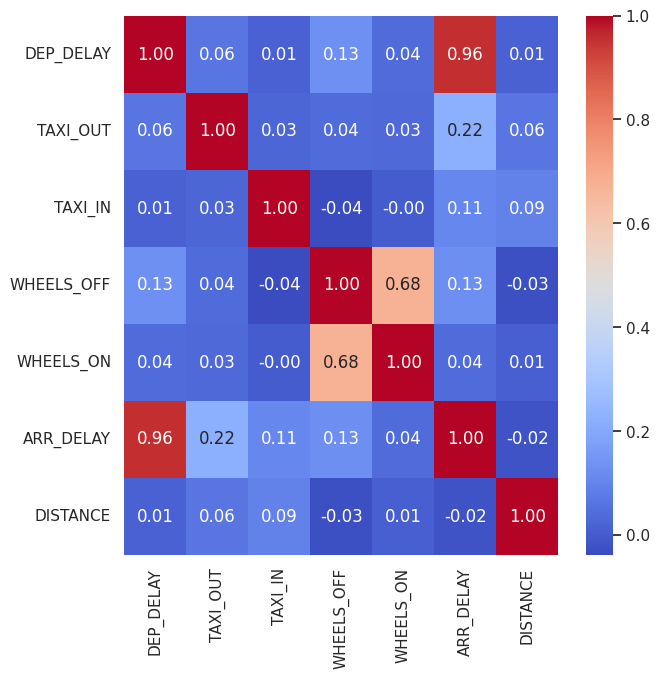

In [ ]:
columns = ['DEP_DELAY','TAXI_OUT','TAXI_IN','WHEELS_OFF','WHEELS_ON','ARR_DELAY','DISTANCE']

# Create a VectorAssembler to convert the columns to a single vector column
assembler = VectorAssembler(inputCols=columns, outputCol="features")
df_vector = assembler.transform(df).select("features")

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()

# Convert the correlation matrix to a pandas DataFrame
correlation_matrix_df = pd.DataFrame(
    correlation_matrix[0].toArray(),
    columns=columns,
    index=columns
)

# Create a heatmap 
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(correlation_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
plt.show()

We can observe strong correlation between ARR_DELAY and DEP_DELAY (fact which can be shown from the previous plot also), hence for the modelling we can classify only one of the 2 variables as target. Basically, we decide to take the DEP_DELAY; this is very obvious since if we have departure delay we will have arrival out of the schedule as well.

# **4. Encoding**

In [ ]:
df_encoded = df

We want to drop all the columns that have actions after the flight was done, because we want to predict either the DEP_DELAY or ARR_DELAY, so we keep only the columns that give us information before the flight begins

In [ ]:
df_encoded = df_encoded.drop('DEP_TIME','TAXI_OUT','WHEELS_OFF','WHEELS_ON','TAXI_IN','ARR_TIME','ACTUAL_ELAPSED_TIME','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY')

We encoded the actual DEP_TIME and ARR_TIME into 4 categories of 24h, so we can manipulate better the data.
So we have:

Night 0-5:59

Morning 6:00-11:59

Afternoon 12:00 - 17:59

Evening 18:00 - 23:59

In [ ]:
df_encoded = df_encoded.withColumn('DEP_Night', when((0 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 600), 1).otherwise(0))
df_encoded = df_encoded.withColumn('DEP_Morning', when((600 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 1200), 1).otherwise(0))
df_encoded = df_encoded.withColumn('DEP_Afternoon', when((1200 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')< 1800), 1).otherwise(0))
df_encoded = df_encoded.withColumn('DEP_Evening', when((1800 <= col('CRS_DEP_TIME')) &  (col('CRS_DEP_TIME')<= 2359), 1).otherwise(0))

df_encoded = df_encoded.withColumn('ARR_Night', when((0 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 600), 1).otherwise(0))
df_encoded = df_encoded.withColumn('ARR_Morning', when((600 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 1200), 1).otherwise(0))
df_encoded = df_encoded.withColumn('ARR_Afternoon', when((1200 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')< 1800), 1).otherwise(0))
df_encoded = df_encoded.withColumn('ARR_Evening', when((1800 <= col('CRS_ARR_TIME')) &  (col('CRS_ARR_TIME')<= 2359), 1).otherwise(0))

df_encoded = df_encoded.drop('FL_DATE','CRS_DEP_TIME','CRS_ARR_TIME')
df_encoded.show(5)

+----------+------+----+---------+---------+----------------+--------+---+-----+----+---------+-----------+-------------+-----------+---------+-----------+-------------+-----------+
|OP_CARRIER|ORIGIN|DEST|DEP_DELAY|ARR_DELAY|CRS_ELAPSED_TIME|DISTANCE|Day|Month|Year|DEP_Night|DEP_Morning|DEP_Afternoon|DEP_Evening|ARR_Night|ARR_Morning|ARR_Afternoon|ARR_Evening|
+----------+------+----+---------+---------+----------------+--------+---+-----+----+---------+-----------+-------------+-----------+---------+-----------+-------------+-----------+
|        9E|   CAE| ATL|       -7|      -22|              71|     192|Sun|    6|2018|        0|          0|            1|          0|        0|          0|            1|          0|
|        9E|   LGA| LEX|       13|       -1|             137|     604|Sun|    6|2018|        0|          0|            0|          1|        0|          0|            0|          1|
|        9E|   DTW| TYS|       -4|      -18|              97|     443|Sun|    6|2018|     

Here we encode the day and the months.

Days take : Day_Mon ... Day_Sun

Months take: Month_1 ... Month_12

In [ ]:
categories = df_encoded.select('Day').distinct().rdd.flatMap(lambda x: x).collect()
for category in categories:
    new_column_name = 'Day_' + category
    df_encoded = df_encoded.withColumn(new_column_name, when(col('Day') == category, 1).otherwise(0))

df_encoded = df_encoded.withColumn("Month", col("Month").cast("string"))
categories = df_encoded.select('Month').distinct().rdd.flatMap(lambda x: x).collect()
for category in categories:
    new_column_name = 'Month_' + category
    df_encoded = df_encoded.withColumn(new_column_name, when(col('Month') == category, 1).otherwise(0))

df_encoded = df_encoded.drop('Day', 'Month')

Similarly, we encode OP_CARRIER, ORIGIN, DEST, where OP_CARRIER is the airline, ORIGIN is the  departure airport, and DEST the arrival airport.

In [ ]:
#encode the OP_CARRIER, ORIGIN, DEST the name of each airline

# use the 'when' function to create a new column for each category
categories = df_encoded.select('OP_CARRIER').distinct().rdd.flatMap(lambda x: x).collect()
for category in categories:
    new_column_name = 'AIRLINE_' + category
    df_encoded = df_encoded.withColumn(new_column_name, when(col('OP_CARRIER') == category, 1).otherwise(0))

categories = df_encoded.select('ORIGIN').distinct().rdd.flatMap(lambda x: x).collect()
for category in categories:
    new_col_name = "OR_" + category
    df_encoded = df_encoded.withColumn(new_col_name, when(col("ORIGIN") == category, 1).otherwise(0))

categories = df_encoded.select('DEST').distinct().rdd.flatMap(lambda x: x).collect()
for category in categories:
    new_col_name = "DEST_" + category
    df_encoded = df_encoded.withColumn(new_col_name, when(col('DEST') == category, 1).otherwise(0))

#delete the OP_CARRIER,ORIGIN, DEST
df_encoded = df_encoded.drop('OP_CARRIER','ORIGIN', 'DEST')


# display the result
df_encoded.show(3)

+---------+---------+----------------+--------+----+---------+-----------+-------------+-----------+---------+-----------+-------------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+-------+-------+--------+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--

In [ ]:
# print the number of departure airports
dep_cols = [col for col in df_encoded.columns if col.startswith('OR_')]
len(dep_cols)

360

In [ ]:
# print the number of arrival airports
dest_cols = [col for col in df_encoded.columns if col.startswith('DEST_')]
len(dest_cols)

360

In [ ]:
# print the number of airlines
airl_cols = [col for col in df_encoded.columns if col.startswith('AIRLINE_')]
len(airl_cols)

18

Here for the classification model we change our DEP_DELAY AND ARR_DELAY into 1 and 0

1 : is for delays

0: is for early and fixed (on time)

In [ ]:
# classify negative delays and fixed as 0 (we do not care if we have negative ones), and positive delays as 1 (== delayed flights)
df_encoded = df_encoded.withColumn("DEP_DELAY", when(df_encoded.DEP_DELAY <= 0, 0).otherwise(1))
df_encoded = df_encoded.withColumn("ARR_DELAY", when(df_encoded.ARR_DELAY <= 0, 0).otherwise(1))
df_encoded.show(3)

+---------+---------+----------------+--------+----+---------+-----------+-------------+-----------+---------+-----------+-------------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+-------+-------+--------+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+--

We took a sample, only the 10% due to computational complexity

In [ ]:
# Take a random sample of 10% of the rows in the dataframe
df_sampled = df_encoded.sample(withReplacement=False, fraction=0.1, seed=42)

# Print the number of rows in the sampled dataframe
print(f"Number of rows in sampled dataframe: {df_sampled.count()}")

# Display the first 5 rows of the sampled dataframe
df_sampled.show(5)

Number of rows in sampled dataframe: 1819515
+---------+---------+----------------+--------+----+---------+-----------+-------------+-----------+---------+-----------+-------------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+-------+-------+-------+--------+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------

# **5. Modelling**

NO FEATURE SELECTION, since the problem we want to answer is classifying a flight as delayed or not by considering specific information-input: 

* Day
* Month
* Departure airport
* Arrival airport
* Airline
* Departure time (period of day)

In [ ]:
# number of columns after endocing 
len(df_sampled.columns)

770

Below for classification models we will use 765 columns for input.

In [ ]:
# specific input columns not to be considered to classify the output DEP_DELAY
exclude_cols = ['DEP_DELAY', 'ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE', 'Year']

# get all columns except for the exclude_cols
input_cols = [col for col in df_sampled.columns if col not in exclude_cols]

target_col = 'DEP_DELAY' 

In [ ]:
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Split the data into training and test sets
train_data, test_data = df_sampled.randomSplit([0.7, 0.3], seed=42)

## 5.1. Naive Bayes (Multinomial model type)

In [ ]:
# Create a multinomial NaiveBayes classifier 
nb = NaiveBayes(labelCol='DEP_DELAY', smoothing=1.0)

# Create a pipeline to assemble the features and train the NaiveBayes classifier
pipeline = Pipeline(stages=[assembler, nb])

# Train the NaiveBayes model on the training data
nb_model = pipeline.fit(train_data)

# Make predictions on the test data
nb_predictions = nb_model.transform(test_data)

# Evaluate the performance of the model using accuracy as the metric
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY', metricName='accuracy')
accuracy = evaluator.evaluate(nb_predictions)

# Print the accuracy of the model on the test data
print(f"Accuracy on test data: {accuracy}")
# confusion matrix of the model on the test data
nb_predictions.groupBy('DEP_DELAY', 'prediction').count().show()

Accuracy on test data: 0.6670660437849226
+---------+----------+------+
|DEP_DELAY|prediction| count|
+---------+----------+------+
|        1|       0.0|114460|
|        0|       0.0|289902|
|        1|       1.0| 74216|
|        0|       1.0| 67272|
+---------+----------+------+



Recall = TP / (TP + FN) = 0.3934

Precision = TP / (TP + FP) = 0.5245

Specificity = TN / (TN + FP) = 0.8117

F1-Score = 2 * (Precision * Recall)/(Precision + Recall) = 0.4496

Below, we want to compare the confusion matrix of the method, by including this time the feature Year, in order to see if it makes any difference.

In [ ]:
# specific input columns not to be considered to classify the output DEP_DELAY
exclude_cols_test = ['DEP_DELAY', 'ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE']

# get all columns except for the exclude_cols
# include now the year
input_cols_test = [col for col in df_sampled.columns if col not in exclude_cols_test]

target_col = 'DEP_DELAY' 

# Assemble features into a single vector column
assembler_test = VectorAssembler(inputCols=input_cols_test, outputCol='features')


# Create a multinomial NaiveBayes classifier 
nb_test = NaiveBayes(labelCol='DEP_DELAY', smoothing=1.0)

# Create a pipeline to assemble the features and train the NaiveBayes classifier
pipeline = Pipeline(stages=[assembler_test, nb_test])

# Train the NaiveBayes model on the training data
nb_test_model = pipeline.fit(train_data)

# Make predictions on the test data
nb_test_predictions = nb_test_model.transform(test_data)

# Evaluate the performance of the model using accuracy as the metric
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY', metricName='accuracy')
accuracy = evaluator.evaluate(nb_test_predictions)

# Print the accuracy of the model on the test data
print(f"Accuracy on test data: {accuracy}")
# confusion matrix of the model on the test data
nb_test_predictions.groupBy('DEP_DELAY', 'prediction').count().show()

Accuracy on test data: 0.666816891087295
+---------+----------+------+
|DEP_DELAY|prediction| count|
+---------+----------+------+
|        1|       0.0|114564|
|        0|       0.0|289888|
|        1|       1.0| 74094|
|        0|       1.0| 67304|
+---------+----------+------+



Fortunately, the above test provides evidence that the variable Year is negligible for our classification problem, hence we are allowed not to include it in our analysis and then we can use only the specific columns just to classify the output DEP_DELAY generally, regardless the year.

In the below models the Year is not included.

## 5.2. Naive Bayes (Bernoulli model type)

In [ ]:
# Train a bernoulli NaiveBayes model 
nb = NaiveBayes(smoothing=1.0, modelType="bernoulli",labelCol='DEP_DELAY',)

# Chain labelIndexer, assembler and NBmodel in a 
pipeline = Pipeline(stages=[assembler, nb])

# Run stages in pipeline and train model
ber_nb_model = pipeline.fit(train_data)

# Make predictions on testData so we can measure the accuracy of our model on new data
ber_nb_predictions = ber_nb_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='DEP_DELAY')
evaluator.evaluate(ber_nb_predictions)
print('Test Area Under Roc',evaluator.evaluate(ber_nb_predictions))

# confusion matrix of the model on the test data
ber_nb_predictions.groupBy('DEP_DELAY', 'prediction').count().show()

Test Area Under Roc 0.6017035876840988
+---------+----------+------+
|DEP_DELAY|prediction| count|
+---------+----------+------+
|        1|       0.0|100113|
|        0|       0.0|267216|
|        1|       1.0| 88545|
|        0|       1.0| 89976|
+---------+----------+------+



Recall = TP / (TP + FN) = 0.4696

Precision = TP / (TP + FP) = 0.4955

Specificity = TN / (TN + FP) = 0.7475

F1-Score = 2 * (Precision * Recall)/(Precision + Recall) = 0.4822

## 5.3. Logistic Regression

In [ ]:
# Create a logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='DEP_DELAY')

# Create a pipeline to assemble the features and train the logistic regression model
pipeline = Pipeline(stages=[assembler, lr])

# Train the logistic regression model on the training data
lr_model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the performance of the model using area under the ROC curve as the metric
evaluator = BinaryClassificationEvaluator(labelCol='DEP_DELAY')
auc = evaluator.evaluate(predictions)

# Print the area under the ROC curve of the model on the test data
print(f"Area under ROC curve on test data: {auc}")

# Calculate the accuracy and confusion matrix of the model on the test data
correct = predictions.filter(predictions.DEP_DELAY == predictions.prediction).count()
total = predictions.count()
accuracy = correct / total
print(f"Accuracy on test data: {accuracy}")

predictions.groupBy('DEP_DELAY', 'prediction').count().show()

Area under ROC curve on test data: 0.6701525379420941
Accuracy on test data: 0.6814729321242099
+---------+----------+------+
|DEP_DELAY|prediction| count|
+---------+----------+------+
|        1|       0.0|141400|
|        0|       0.0|324724|
|        1|       1.0| 47258|
|        0|       1.0| 32468|
+---------+----------+------+



Recall = TP / (TP + FN) = 0.2515

Precision = TP / (TP + FP) = 0.5929

Specificity = TN / (TN + FP) = 0.9088

F1-Score = 2 * (Precision * Recall)/(Precision + Recall) = 0.3532

## 5.4. Random Forest Classifier

In [ ]:
df_rf = assembler.transform(df_sampled).select("features", target_col)
train, test = df_rf.randomSplit([0.7, 0.3], seed=12345) # 4

# Train the Random Forest classifier
rf = RandomForestClassifier(labelCol=target_col, featuresCol="features", numTrees=10, maxDepth=10, seed=12345)
model = rf.fit(train)

# Make predictions on the test set
rf_predictions = model.transform(test)

# Compute accuracy using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol=target_col)
accuracy = evaluator.evaluate(rf_predictions)

print("Accuracy: {:.2f}".format(accuracy))

# confusion matrix of the model on the test data
rf_predictions.groupBy('DEP_DELAY', 'prediction').count().show()

Accuracy: 0.64
+---------+----------+------+
|DEP_DELAY|prediction| count|
+---------+----------+------+
|        1|       0.0|189040|
|        0|       0.0|356737|
|        1|       1.0|   217|
|        0|       1.0|    94|
+---------+----------+------+



Recall = TP / (TP + FN) = 0.001

Precision = TP / (TP + FP) = 0.6977

Specificity = TN / (TN + FP) = 0.9997

F1-Score = 2 * (Precision * Recall)/(Precision + Recall) = 0.002

## 5.5. Gradient - Boosted Trees Classifier

In [ ]:
# create a GBT classifier model
gbt = GBTClassifier(labelCol=target_col, featuresCol='features')

# create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# fit the pipeline model on training data
model = pipeline.fit(train_data)

# make predictions on test data
predictions = model.transform(test_data)

# evaluate the model using AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol=target_col)
auc_roc = evaluator.evaluate(predictions)

# print the AUC-ROC score
print('AUC-ROC: ', auc_roc)

# compute the confusion matrix
tp = predictions[(predictions[target_col] == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions[target_col] == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions[target_col] == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions[target_col] == 1) & (predictions.prediction == 0)].count()

print('Confusion matrix:')
print('TP: ', tp)
print('TN: ', tn)
print('FP: ', fp)
print('FN: ', fn)

AUC-ROC:  0.6678820629133324
Confusion matrix:
TP:  43427
TN:  327798
FP:  29376
FN:  145249


Recall = TP / (TP + FN) = 0.2302

Precision = TP / (TP + FP) = 0.5965

Specificity = TN / (TN + FP) = 0.9178

F1-Score = 2 * (Precision * Recall)/(Precision + Recall) = 0.3322

## Naive Bayes using all the data of 2018

In [ ]:
# take only the rows of Year 2018 of df_encoded 
df_class = df_encoded.filter(df_encoded.Year == 2018)

In [ ]:
# specific input columns not to be considered to classify the output DEP_DELAY
ex_cols = ['DEP_DELAY', 'ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE', 'Year']

# get all columns except for the exclude_cols
in_cols = [col for col in df_class.columns if col not in ex_cols]

target_col = 'DEP_DELAY' 

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Split the data into training and test sets
train_data_class, test_data_class = df_class.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# Create a multinomial NaiveBayes classifier 
nb_class = NaiveBayes(labelCol='DEP_DELAY', smoothing=1.0)

# Create a pipeline to assemble the features and train the NaiveBayes classifier
pipeline = Pipeline(stages=[assembler, nb_class])

# Train the NaiveBayes model on the training data
nb_class_model = pipeline.fit(train_data_class)

# Make predictions on the test data
nb_predictions_class = nb_class_model.transform(test_data_class)

# Evaluate the performance of the model using accuracy as the metric
evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY', metricName='accuracy')
accuracy = evaluator.evaluate(nb_predictions_class)

# Print the accuracy of the model on the test data
print(f"Accuracy on test data: {accuracy}")
# confusion matrix of the model on the test data
nb_predictions_class.groupBy('DEP_DELAY', 'prediction').count().show()

Accuracy on test data: 0.673331485660741
+---------+----------+-------+
|DEP_DELAY|prediction|  count|
+---------+----------+-------+
|        1|       0.0| 455590|
|        0|       0.0|1152764|
|        1|       1.0| 275768|
|        0|       1.0| 237466|
+---------+----------+-------+



Recall = TP / (TP + FN) = 0.3771

Precision = TP / (TP + FP) = 0.5373

Specificity = TN / (TN + FP) = 0.8292

F1-Score = 2 * (Precision * Recall)/(Precision + Recall) = 0.4432

We can observe that by using more data (over 5milions more, by taking all the flights that occured in 2018) the evaluation metrics of the best model are negligibly different than the sample of the all data; altough the accuracy is better the f1-score is worse. 

# **6. Results**

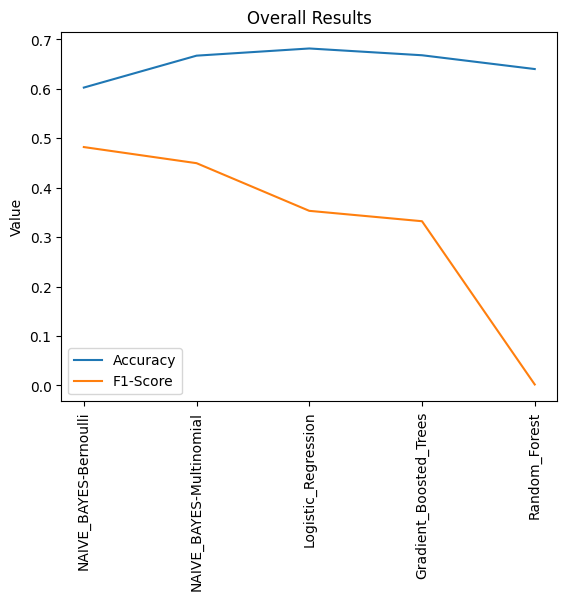

In [ ]:
models_res = pd.DataFrame({'Model':['NAIVE_BAYES-Multinomial','NAIVE_BAYES-Bernoulli','Logistic_Regression','Random_Forest','Gradient_Boosted_Trees'], 'Accuracy':[0.6670660437849226,0.6025104219595718,0.6815920124576349,0.64,0.6678820629133324], 'F1_Score':[0.4496,0.4822,0.3532,0.002,0.3322]})
models_res = models_res.sort_values(by=['F1_Score'],ascending=False)
plt.plot(models_res['Model'],models_res['Accuracy'], label='Accuracy')
plt.plot(models_res['Model'],models_res['F1_Score'], label='F1-Score')
plt.ylabel("Value")
plt.legend(loc="lower left")
plt.xticks(rotation=90)
plt.title("Overall Results")
plt.show()

In general, as we had seen before in exploratory subset, our data is imbalanced in terms of the response DEP_DELAY; dataset consists of 10,956,138 early flights and 943,265 on-time, hence 11,899,403 negative values (label '0') whereas the rest 6,289,969 are delays, ie positive values (label '1'). Basically, we have about 50% more negative values. 

Concerning the modelling, we have just use only 10% of overall data, where particularly in test set we have 188,676 (in random forest 189,257) positive and 357,174 (in random forest 356,836) negative values, hence again the rate P/N is around 1/2. Thus, we cannot evaluate the models based only on the accuracy, but we should focus also on either precision or recall or we can better select according the f1-score. Particularly, all our models provide very bad recall, since they cannot predict correctly all the positive values due to the fact they did not be trainned in positive values during the fitting phase.

Considering all the mentioned before, Naive Bayes by using the multinomial modeltype is the optimal one with f1-score at about 0.45 and accuracy at around 0.67.



Now, we can use the selected above model, Naive Bayes by using the multinomial modeltype, and explore which airlines, days, months and periods of day have the most probability to have departure delay.

In [ ]:
# get the class conditional probabilities
class_conditional_probs = nb_model.stages[-1].theta.toArray()

# get the class priors
class_priors = nb_model.stages[-1].pi.toArray()

In [ ]:
# create a dictionary to store the months probabilities
months_probs = {}
months_cols = [col for col in df_sampled.columns if col.startswith('Month_')]
# loop through each month column
for months_col in months_cols:

    # compute the index of the day column
    months_index = input_cols.index(months_col)

    # compute the probability of the day using the class conditional probabilities and class priors
    months_prob = (class_conditional_probs[:, months_index] * class_priors).sum()

    # add the months probability to the dictionary
    months_probs[months_col] = months_prob

# sort the monthsprobabilities in descending order
months_probs = {k: v for k, v in sorted(months_probs.items(), key=lambda item: item[1], reverse=True)}

# print the top 10 worst months with the highest probability to have delay
print('Μonths with the probability to have delay:')
for months, prob in list(months_probs.items())[::-1]:
    months_prob = nb_predictions.select(col(months)).groupBy().avg().collect()[0][0]
    print(months, months_prob)

Μonths with the probability to have delay:
Month_7 0.08949161857653201
Month_8 0.08949161857653201
Month_6 0.08744526884675277
Month_5 0.08585692039937712
Month_12 0.08237427864798022
Month_3 0.08515159842447559
Month_4 0.08218558211962994
Month_10 0.08520839058349364
Month_1 0.07838600348080975
Month_11 0.08153705230374646
Month_9 0.08019236053860951
Month_2 0.072679307502061


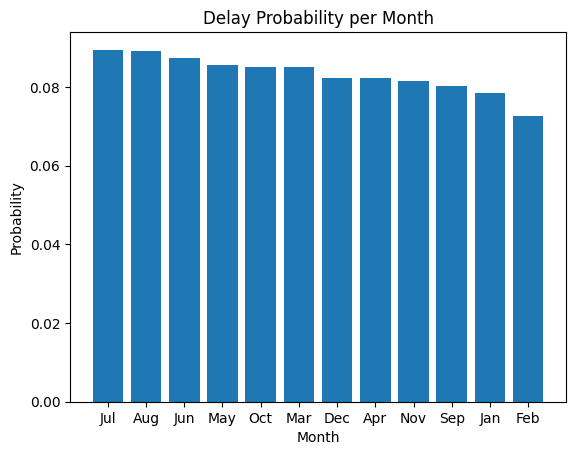

In [ ]:
# manually do the graph, to save computation time
month_classif = pd.DataFrame({'Month':['Jul','Aug','Jun','May','Dec','Mar','Apr','Oct','Jan','Nov','Sep','Feb'],'Probs':[0.08948245855088394,0.08925712191994138,0.08744526884675277,0.08558211962993496,0.08237427864798022,0.08515159842447559,0.08218558211962994,0.08520839058349364,0.07838600348080975,0.08153705230374646,0.08019236053860951,0.072679307502061]})
month_classif = month_classif.sort_values(by=['Probs'],ascending=False)
plt.bar(month_classif['Month'],month_classif['Probs'])
plt.title("Delay Probability per Month")
plt.xlabel("Month")
plt.ylabel("Probability")
plt.show()

The worst months for departure delay are the ones of summer, whereas February is the one with the lowest probability to have delay. However, the month can be considered negligible for the delay, since the probabilities are too low as well as there is not significant difference between the different months.

In [ ]:
# create a dictionary to store the airline probabilities
airline_probs = {}
airline_cols = [col for col in df_sampled.columns if col.startswith('AIRLINE_')]
# loop through each airline column
for airline_col in airline_cols:

    # compute the index of the airline column
    airline_index = input_cols.index(airline_col)

    # compute the probability of the airline using the class conditional probabilities and class priors
    airline_prob = (class_conditional_probs[:, airline_index] * class_priors).sum()

    # add the airline probability to the dictionary
    airline_probs[airline_col] = airline_prob

# sort the airline probabilities in descending order
airline_probs = {k: v for k, v in sorted(airline_probs.items(), key=lambda item: item[1], reverse=True)}

# print the top 5 worst airlines with the highest probability to have delay
print('Airlines with the probability to have delay:')
for airline, prob in list(airline_probs.items())[::-1]:
    airline_prob = nb_predictions.select(col(airline)).groupBy().avg().collect()[0][0]
    print(airline, airline_prob)

Airlines with the probability to have delay:
AIRLINE_WN 0.21529357882202071
AIRLINE_AA 0.14816891087295045
AIRLINE_DL 0.15227809837867545
AIRLINE_OO 0.1130109004305212
AIRLINE_UA 0.09536319501694605
AIRLINE_B6 0.04760831730328845
AIRLINE_EV 0.05502793807822662
AIRLINE_AS 0.03297975634331776
AIRLINE_NK 0.025587615645323806
AIRLINE_F9 0.01722817623889347
AIRLINE_OH 0.014718329211321792
AIRLINE_MQ 0.015379683063112578
AIRLINE_YX 0.016803151048822938
AIRLINE_HA 0.012842355958596684
AIRLINE_9E 0.012600531281487588
AIRLINE_YV 0.011528808280663185
AIRLINE_VX 0.008375927452596868
AIRLINE_G4 0.005204726573234405


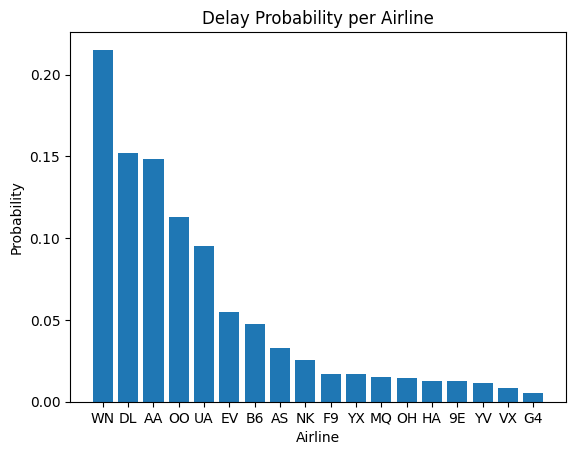

In [ ]:
# manually do the graph, to save computation time
airlines_classif = pd.DataFrame({'Airline':['WN','AA','DL','OO','UA','B6','EV','AS','NK','F9','OH','MQ','YX','HA','9E','YV','VX','G4'],'Probs':[0.21529357882202071,0.14816891087295045,0.15227809837867545,0.1130109004305212,0.09536319501694605,
                                                                                                                                                0.04760831730328845,0.05502793807822662,0.03297975634331776,0.025587615645323806,0.01722817623889347,
                                                                                                                                                0.014718329211321792,0.015379683063112578,0.016803151048822938,0.012842355958596684,0.012600531281487588,
                                                                                                                                                0.011528808280663185,0.008375927452596868,0.005204726573234405]})
airlines_classif = airlines_classif.sort_values(by=['Probs'],ascending=False)
plt.bar(airlines_classif['Airline'],airlines_classif['Probs'])
plt.title("Delay Probability per Airline")
plt.xlabel("Airline")
plt.ylabel("Probability")
plt.show()

In our dataset we have 18 airlines. The 5 worst airlines in terms of the departure delay are Southwest Airlines (WN), Delta Airlines (DL), American Airlines (AA), SkyWest Airlines (OO), and United Airlines (UA), which have probability about more than 0.1 to have delay.

reference: https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States

In [ ]:
# create a dictionary to store the day probabilities
days_probs = {}
days_cols = [col for col in df_sampled.columns if col.startswith('Day_')]
# loop through each day column
for days_col in days_cols:

    # compute the index of the day column
    days_index = input_cols.index(days_col)

    # compute the probability of the day using the class conditional probabilities and class priors
    days_prob = (class_conditional_probs[:, days_index] * class_priors).sum()

    # add the days probability to the dictionary
    days_probs[days_col] = days_prob

# sort the days probabilities in descending order
days_probs = {k: v for k, v in sorted(days_probs.items(), key=lambda item: item[1], reverse=True)}

# print the top 10 worst days with the highest probability to have delay
print('Days with the probability to have delay:')
for days, prob in list(days_probs.items())[::-1]:
    days_prob = nb_predictions.select(col(days)).groupBy().avg().collect()[0][0]
    print(days, days_prob)

Days with the probability to have delay:
Day_Fri 0.15015663643858204
Day_Thu 0.1474983969955116
Day_Mon 0.14841439956031877
Day_Wed 0.145814784281396
Day_Sun 0.14188146926811396
Day_Tue 0.14378675460291288
Day_Sat 0.12244755885316479


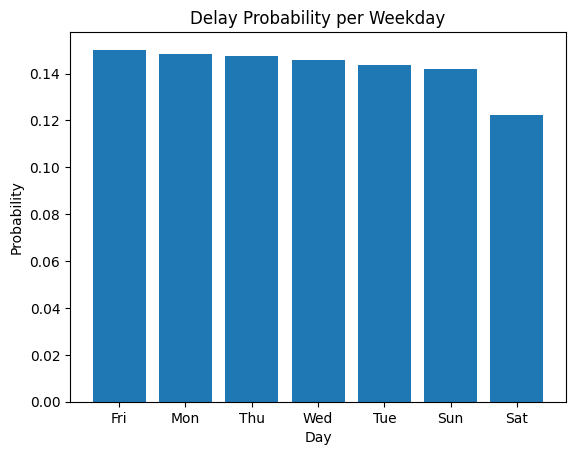

In [ ]:
# manually do the graph, to save computation time
day_classif = pd.DataFrame({'Day':['Fri','Thu','Mon','Wed','Sun','Tue','Sat'],'Probs':[0.15015663643858204,0.1474983969955116,0.14841439956031877,0.145814784281396,0.14188146926811396,0.14378675460291288,0.12244755885316479]})
day_classif = day_classif.sort_values(by=['Probs'],ascending=False)
plt.bar(day_classif['Day'],day_classif['Probs'])
plt.title("Delay Probability per Weekday")
plt.xlabel("Day")
plt.ylabel("Probability")
plt.show()

We observe that Fridays, Mondays, Thursdays, and Wednesdays are the days with the highest probability to have delay whereas Saturdays are the best ones. However, the difference can be assumed negligible, hence the day does not play significance role on the departure delay of a flight.

In [ ]:
# create a dictionary to store the period probabilities
periods_probs = {}
periods_cols = [col for col in df_sampled.columns if col.startswith('DEP_')]
periods_cols = [col for col in periods_cols if col != 'DEP_DELAY']

# loop through each period column
for periods_col in periods_cols:

    # compute the index of the day column
    periods_index = input_cols.index(periods_col)

    # compute the probability of the day using the class conditional probabilities and class priors
    periods_prob = (class_conditional_probs[:, periods_index] * class_priors).sum()

    # add the periods probability to the dictionary
    periods_probs[periods_col] = periods_prob

# sort the periods probabilities in descending order
periods_probs = {k: v for k, v in sorted(periods_probs.items(), key=lambda item: item[1], reverse=True)}

# print the periods with the probability to have delay
print('Periods with the probability to have delay:')
for period, prob in list(periods_probs.items()):
    periods_prob = nb_predictions.select(col(period)).groupBy().avg().collect()[0][0]
    print(period, periods_prob)

Periods with the probability to have delay:
DEP_Night 0.02746725290830814
DEP_Evening 0.22031327287716407
DEP_Morning 0.3900668681872309
DEP_Afternoon 0.3621526060272969


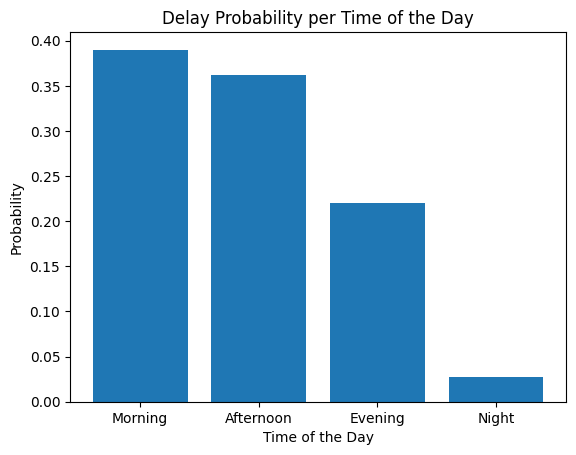

In [ ]:
# manually do the graph, to save computation time
part_of_day_classif = pd.DataFrame({'Part':['Night','Evening','Morning','Afternoon'],'Probs':[0.02746725290830814,0.22031327287716407,0.3900668681872309,0.3621526060272969]})
part_of_day_classif = part_of_day_classif.sort_values(by=['Probs'],ascending=False)
plt.bar(part_of_day_classif['Part'],part_of_day_classif['Probs'])
plt.title("Delay Probability per Time of the Day")
plt.xlabel("Time of the Day")
plt.ylabel("Probability")
plt.show()

We can observe that it is more common for flights which are taken place during morning or afternoon to have delay at the departure airport, while flights during the night rarely have delay.